# Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from math import sqrt
from transformers import LlamaConfig, LlamaModel, LlamaTokenizer, GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, BertModel, BertTokenizer
import transformers
import accelerate
from torch import nn, optim
import torch.nn.functional as F
from torch import Tensor
from torch.nn.utils import weight_norm
import math
from torch.utils.data import TensorDataset, DataLoader, random_split, Subset
import torch
from torchmetrics.regression import R2Score
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import BitsAndBytesConfig
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import random
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from torch.utils.tensorboard import SummaryWriter
import time
import itertools
import ramanspy as rs
from ramanspy import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA
import seaborn as sns


# Raman-LLM

| Parameter     | Meaning | 
|:---------|:---:|
| pred_len   | How many futuresteps the model should predict./Number of classes if classficiation  |    
| seq_len   | How many past time-steps are given the model as input.   |     
| d_ff     | The size of the vectors extracted from the LLM’s hidden states before the final head. This is the “feature‐for‐forecast” dimension.  |      
| patch_len     | How many consecutive time‐steps make up one patch when we slice your series.  |   
| stride     | How far you shift your sliding window between patches.   |   
| llm_layers     | How many Transformer layers we want to use from the pretrained LLM.  |   
| d_model     | The hidden‐dimensionality of your patch embeddings (the output of the Conv1d). In Transformer terms, this is the “model width.”  |   
| n_heads     | The number of attention heads in your ReprogrammingLayer.   |   
| enc_in     | Number of parallel input channels (i.e. number of series or variables).   |   
| d_llm     | The hidden‐state size of the LLM.  |   



Hyperparameters of the model:


In [9]:
class Details:
    def __init__(self, pred_len,seq_len,d_ff,stride,llm_layers, description, dropout, 
                 d_model, n_heads,enc_in, patch_len, d_llm,llm_model, lr, task = 'regression'):
        self.task = task
        self.pred_len = pred_len 
        self.seq_len = seq_len 
        self.d_ff = d_ff 
        self.patch_len = patch_len
        self.stride = stride
        self.llm_layers = llm_layers
        self.content = description
        self.dropout = dropout
        self.d_model = d_model
        self.enc_in = enc_in 
        self.n_heads = n_heads
        self.d_llm = d_llm
        self.llm_model = llm_model
        self.lr = lr

Raman-LLM

In [10]:
transformers.logging.set_verbosity_error()

class FlattenHead(nn.Module):
    def __init__(self, n_vars, nf, target_window, head_dropout=0):
        super().__init__()
        self.n_vars = n_vars
        self.flatten = nn.Flatten(start_dim=-2)
        self.linear = nn.Linear(nf, target_window)
        self.dropout = nn.Dropout(head_dropout)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        x = self.dropout(x)
        return x
    
class Model(nn.Module):
    #configs represents the details of the task and hyperparameters
    def __init__(self, configs, patch_len=16, stride=8):
        super(Model, self).__init__()
        self.task = configs.task
        self.pred_len = configs.pred_len
        self.seq_len = configs.seq_len
        self.d_ff = configs.d_ff
        self.top_k = 5
        self.d_llm = configs.d_llm
        self.patch_len = configs.patch_len
        self.stride = configs.stride

        if configs.llm_model == 'LLAMA':
            self.llama_config = LlamaConfig.from_pretrained('huggyllama/llama-7b')
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True

            self.llm_model = LlamaModel.from_pretrained(
                        'huggyllama/llama-7b',
                        trust_remote_code=True,
                        local_files_only=True,
                        config=self.llama_config,
                    )
            
            self.tokenizer = LlamaTokenizer.from_pretrained(
                        'huggyllama/llama-7b',
                        trust_remote_code=True,
                        local_files_only=True
                    )
        elif configs.llm_model == 'GPT2':

            self.gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')
            self.gpt2_config.num_hidden_layers = configs.llm_layers
            self.gpt2_config.output_attentions = True
            self.gpt2_config.output_hidden_states = True

            self.llm_model = GPT2Model.from_pretrained(
                        'openai-community/gpt2',
                        trust_remote_code=True,
                        #local_files_only=True,
                        config=self.gpt2_config,
                    )
            self.tokenizer = GPT2Tokenizer.from_pretrained(
                        'openai-community/gpt2',
                        trust_remote_code=True,
                        #local_files_only=True
                    )
            
        elif configs.llm_model == 'BERT':

            self.bert_config = BertConfig.from_pretrained('google-bert/bert-base-uncased')

            self.bert_config.num_hidden_layers = configs.llm_layers
            self.bert_config.output_attentions = True
            self.bert_config.output_hidden_states = True

            self.llm_model = BertModel.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True,
                    config=self.bert_config,
                )
    
            self.tokenizer = BertTokenizer.from_pretrained(
                    'google-bert/bert-base-uncased',
                    trust_remote_code=True,
                    local_files_only=True
                )

        else:
            bnb_config = BitsAndBytesConfig(
                load_in_8bit=True,  
                bnb_4bit_use_double_quant=True,
                bnb_4bit_compute_dtype=torch.float16,
                bnb_4bit_quant_type="nf4",
            )

            self.llama_config = AutoConfig.from_pretrained("TheBloke/LLaMA-7B-GGML")
            self.llama_config.num_hidden_layers = configs.llm_layers
            self.llama_config.output_attentions = True
            self.llama_config.output_hidden_states = True

            self.llm_model = AutoModel.from_pretrained(
                "TheBloke/LLaMA-7B-GGML",
                config=self.llama_config,
                device_map="auto",
                quantization_config=bnb_config,
                trust_remote_code=True,
                from_tf=True
            )

            self.tokenizer = AutoTokenizer.from_pretrained(
                "TheBloke/LLaMA-7B-GGML",
                trust_remote_code=True
            )

        
        if self.tokenizer.eos_token:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            pad_token = '[PAD]'
            self.tokenizer.add_special_tokens({'pad_token': pad_token})
            self.tokenizer.pad_token = pad_token

        #Freeze parameters of LLM:
        for param in self.llm_model.parameters():
            param.requires_grad = False
        
        self.description = configs.content

        self.dropout = nn.Dropout(configs.dropout)

        self.patch_embedding = PatchEmbedding(
            configs.d_model, self.patch_len, self.stride, configs.dropout)

        self.word_embeddings = self.llm_model.get_input_embeddings().weight
        self.vocab_size = self.word_embeddings.shape[0]
        self.num_tokens = 1000
        self.mapping_layer = nn.Linear(self.vocab_size, self.num_tokens)

        self.reprogramming_layer = ReprogrammingLayer(configs.d_model, configs.n_heads, self.d_ff, self.d_llm)


        self.patch_nums = int((configs.seq_len - self.patch_len) / self.stride + 2)
        self.head_nf = self.d_ff * self.patch_nums

        self.output_projection = FlattenHead(configs.enc_in, self.head_nf, self.pred_len, head_dropout=configs.dropout)

        self.normalize_layers = Normalize(configs.enc_in, affine=False)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec, mask=None):
        if self.task == 'classification':
            f = self.classify(x_enc, x_mark_enc, x_dec, x_mark_dec)
        else:
            dec_out = self.forecast(x_enc, x_mark_enc, x_dec, x_mark_dec)
            f = dec_out[:, -self.pred_len:, :]
        return f

    def forecast(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x_enc = self.normalize_layers(x_enc, 'norm')
        B, T, N = x_enc.size()

        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)

        min_values = torch.min(x_enc, dim=1)[0]        
        max_values = torch.max(x_enc, dim=1)[0]        
        medians = torch.median(x_enc, dim=1).values 
 
        lags = self.calcute_lags(x_enc)          
         
        trends = x_enc.diff(dim=1).sum(dim=1)      

        prompt = []
        for b in range(x_enc.shape[0]):  
            min_values_str    = str(min_values[b].tolist()[0])
            max_values_str    = str(max_values[b].tolist()[0])
            median_values_str = str(medians[b].tolist()[0])
            lags_values_str   = str(lags[b].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description} "
                f"Task description: predict the concentration "
                f"given {str(self.seq_len)} of the spectra; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {median_values_str}, "
                f"the trend of input is {'upward' if trends[b] > 0 else 'downward'}, "
                f"top 5 lags are: {lags_values_str}<|<end_prompt>|>"
            )
            prompt.append(prompt_)
        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous()

        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt.to(x_enc.device))  

        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0)

        x_enc = x_enc.permute(0, 2, 1).contiguous()
        enc_out, n_vars = self.patch_embedding(x_enc) 
        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)
        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state
        dec_out = dec_out[:, :, :self.d_ff]

        dec_out = torch.reshape(
            dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:])
        dec_out = dec_out.permute(0, 2, 1).contiguous()

        dec_out = self.normalize_layers(dec_out, 'denorm')
        return dec_out

    def calcute_lags(self, x_enc):
        q_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        k_fft = torch.fft.rfft(x_enc.permute(0, 2, 1).contiguous(), dim=-1)
        res = q_fft * torch.conj(k_fft)
        corr = torch.fft.irfft(res, dim=-1)
        mean_value = torch.mean(corr, dim=1)
        _, lags = torch.topk(mean_value, self.top_k, dim=-1)
        return lags
    
    def classify(self, x_enc, x_mark_enc, x_dec, x_mark_dec):
        x_enc = self.normalize_layers(x_enc, 'norm')
        B, T, N = x_enc.size()
        x_enc = x_enc.permute(0, 2, 1).contiguous().reshape(B * N, T, 1)
  
        min_values = torch.min(x_enc, dim=1)[0]        
        max_values = torch.max(x_enc, dim=1)[0]        
        medians = torch.median(x_enc, dim=1).values 
 
        lags = self.calcute_lags(x_enc)          
         
        trends = x_enc.diff(dim=1).sum(dim=1)      

        prompt = []

        for b in range(x_enc.shape[0]):  
            min_values_str    = str(min_values[b].tolist()[0])
            max_values_str    = str(max_values[b].tolist()[0])
            median_values_str = str(medians[b].tolist()[0])
            lags_values_str   = str(lags[b].tolist())
            prompt_ = (
                f"<|start_prompt|>Dataset description: {self.description} "
                f"Task description: classify the input sequence in one of the {str(self.pred_len)} classes "
                f"given the previous {str(self.seq_len)} steps information; "
                "Input statistics: "
                f"min value {min_values_str}, "
                f"max value {max_values_str}, "
                f"median value {median_values_str}, "
                f"the trend of input is {'upward' if trends[b] > 0 else 'downward'}, "
                f"top 5 lags are: {lags_values_str}<|<end_prompt>|>"
            )
            prompt.append(prompt_)
            
        x_enc = x_enc.reshape(B, N, T).permute(0, 2, 1).contiguous()

        prompt = self.tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048).input_ids
        prompt_embeddings = self.llm_model.get_input_embeddings()(prompt.to(x_enc.device))  

        source_embeddings = self.mapping_layer(self.word_embeddings.permute(1, 0)).permute(1, 0)

        x_enc = x_enc.permute(0, 2, 1).contiguous()
        enc_out, n_vars = self.patch_embedding(x_enc) 

        enc_out = self.reprogramming_layer(enc_out, source_embeddings, source_embeddings)

        llama_enc_out = torch.cat([prompt_embeddings, enc_out], dim=1)
        dec_out = self.llm_model(inputs_embeds=llama_enc_out).last_hidden_state

        dec_out = dec_out[:, :, :self.d_ff]
        
        dec_out = torch.reshape(dec_out, (-1, n_vars, dec_out.shape[-2], dec_out.shape[-1]))
        dec_out = dec_out.permute(0, 1, 3, 2).contiguous()

        dec_out = self.output_projection(dec_out[:, :, :, -self.patch_nums:]).squeeze(1)
        return dec_out  
    
    
class ReprogrammingLayer(nn.Module):
    
    def __init__(self, d_model, n_heads, d_keys=None, d_llm=None, attention_dropout=0.1):
        super(ReprogrammingLayer, self).__init__()

        d_keys = d_keys or (d_model // n_heads)

        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.value_projection = nn.Linear(d_llm, d_keys * n_heads)
        self.out_projection = nn.Linear(d_keys * n_heads, d_llm)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(attention_dropout)
    
    def forward(self, target_embedding, source_embedding, value_embedding):
        B, L, _ = target_embedding.shape
        S, _ = source_embedding.shape
        H = self.n_heads

        target_embedding = self.query_projection(target_embedding).view(B, L, H, -1)
        source_embedding = self.key_projection(source_embedding).view(S, H, -1)
        value_embedding = self.value_projection(value_embedding).view(S, H, -1)

        out = self.reprogramming(target_embedding, source_embedding, value_embedding)

        out = out.reshape(B, L, -1)

        return self.out_projection(out)

    def reprogramming(self, target_embedding, source_embedding, value_embedding):
        B, L, H, E = target_embedding.shape

        scale = 1. / sqrt(E)

        scores = torch.einsum("blhe,she->bhls", target_embedding, source_embedding)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        reprogramming_embedding = torch.einsum("bhls,she->blhe", A, value_embedding)

        return reprogramming_embedding
    
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__ >= '1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=padding, padding_mode='circular', bias=False)
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1, 2)
        return x


class ReplicationPad1d(nn.Module):
    def __init__(self, padding) -> None:
        super(ReplicationPad1d, self).__init__()
        self.padding = padding

    def forward(self, input: Tensor) -> Tensor:
        replicate_padding = input[:, :, -1].unsqueeze(-1).repeat(1, 1, self.padding[-1])
        output = torch.cat([input, replicate_padding], dim=-1)
        return output


class PatchEmbedding(nn.Module):
    def __init__(self, d_model, patch_len, stride, dropout):
        super(PatchEmbedding, self).__init__()

        self.patch_len = patch_len
        self.stride = stride
        self.padding_patch_layer = ReplicationPad1d((0, stride))

        self.value_embedding = TokenEmbedding(patch_len, d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        n_vars = x.shape[1]
        x = self.padding_patch_layer(x)
        x = x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        x = torch.reshape(x, (x.shape[0] * x.shape[1], x.shape[2], x.shape[3]))

        x = self.value_embedding(x)
        return self.dropout(x), n_vars

class Normalize(nn.Module):
    def __init__(self, num_features: int, eps=1e-5, affine=False, subtract_last=False, non_norm=False):
       
        super(Normalize, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.affine = affine
        self.subtract_last = subtract_last
        self.non_norm = non_norm
        if self.affine:
            self._init_params()

    def forward(self, x, mode: str):
        if mode == 'norm':
            self._get_statistics(x)
            x = self._normalize(x)
        elif mode == 'denorm':
            x = self._denormalize(x)
        else:
            raise NotImplementedError
        return x

    def _init_params(self):

        self.affine_weight = nn.Parameter(torch.ones(self.num_features))
        self.affine_bias = nn.Parameter(torch.zeros(self.num_features))

    def _get_statistics(self, x):
        dim2reduce = tuple(range(1, x.ndim - 1))
        if self.subtract_last:
            self.last = x[:, -1, :].unsqueeze(1)
        else:
            self.mean = torch.mean(x, dim=dim2reduce, keepdim=True).detach()
        self.stdev = torch.sqrt(torch.var(x, dim=dim2reduce, keepdim=True, unbiased=False) + self.eps).detach()

    def _normalize(self, x):
        if self.non_norm:
            return x
        if self.subtract_last:
            x = x - self.last
        else:
            x = x - self.mean
        x = x / self.stdev
        if self.affine:
            x = x * self.affine_weight
            x = x + self.affine_bias
        return x

    def _denormalize(self, x):
        if self.non_norm:
            return x
        if self.affine:
            x = x - self.affine_bias
            x = x / (self.affine_weight + self.eps * self.eps)
        x = x * self.stdev
        if self.subtract_last:
            x = x + self.last
        else:
            x = x + self.mean
        return x


Training pipeline

In [11]:
def train_model(configs, train, validation, epochs, batch_size, updates, earlystop, patience = 10, file_name = 'best_model.pth', scale_wavelengths = True, save = True):

    #Scale spectra
    
    train.columns = train.columns.astype(str)
    scaler = StandardScaler()
    normalized = scaler.fit_transform(train.iloc[:,1:].T).T
    X_train_n = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

    validation.columns = validation.columns.astype(str)
    normalized = scaler.fit_transform(validation.iloc[:,1:].T).T
    X_val_n = pd.DataFrame(normalized, columns = validation.iloc[:,1:].columns)
    
    #Scale wavelengths

    stand = StandardScaler()
    
    if scale_wavelengths:
        scaled = stand.fit_transform(X_train_n)
        X_train_n = pd.DataFrame(scaled, columns = X_train_n.columns)
        scaled = stand.transform(X_val_n)
        X_val_n = pd.DataFrame(scaled, columns = X_val_n.columns)
    
    
    #Prepare tensor dataset

    pred_len = configs.pred_len
    seq_len = configs.seq_len
    n_vars = 1
    N_train =  X_train_n.shape[0]
    N_val = X_val_n.shape[0]

    X = torch.from_numpy(X_train_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y = torch.from_numpy(train.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)
                
    X2 = torch.from_numpy(X_val_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y2 = torch.from_numpy(validation.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1).unsqueeze(1)
                
    train_ds = TensorDataset(X, y)
    val_ds = TensorDataset(X2, y2)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)

    #Train model 
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(configs).to(device)
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=configs.lr)
    criterion = torch.nn.MSELoss()

    num_epochs = epochs

    #Early stop

    best_val_rmse = float('inf')

    counter = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        sum_mse = 0.0
        r2_metric = R2Score()
        for x_enc, y_true in train_loader:
            x_enc, y_true = x_enc.float().to(device), y_true.float().to(device)
            opt.zero_grad()
            y_pred = model(x_enc, None, None, None)  
            loss = criterion(y_pred, y_true)
            loss.backward()
            opt.step()
            sum_mse += loss.item()*x_enc.size(0)
            r2_metric.update(y_pred.reshape(-1), y_true.reshape(-1))

            del y_pred, loss  # Free up memory
            #torch.cuda.empty_cache()

        train_mse = sum_mse / N_train
        train_rmse = sqrt(train_mse)
        train_r2 = r2_metric.compute()


        model.eval()
        sum_mse = 0.0
        r2_metric2 = R2Score()
        with torch.no_grad():
            for x_enc, y_true in val_loader:
                x_enc, y_true = x_enc.to(device), y_true.to(device)
                y_pred = model(x_enc, None, None, None)
                sum_mse += criterion(y_pred, y_true).item() * x_enc.size(0)
                r2_metric2.update(y_pred.reshape(-1), y_true.reshape(-1))

                del y_pred  # Free up memory
                #torch.cuda.empty_cache()


        val_mse = sum_mse / N_val
        val_rmse = sqrt(val_mse)
        val_r2 = r2_metric2.compute()

        if updates:
            print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
            
        if earlystop:
            if val_rmse < best_val_rmse:
                best_val_rmse = val_rmse
                best_train_rmse = train_rmse
                best_train_r2 = train_r2
                best_val_r2 = val_r2
                counter = 0
                if save:
                    torch.save(model.state_dict(), file_name)  # Save best model
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs")
                    break
    
    print(f"Best results — train RMSE {best_train_rmse:.6f} - train R2 {best_train_r2:.6f} — val RMSE {best_val_rmse:.6f} - val R2 {best_val_r2:.6f}")

    return model, best_train_rmse, best_train_r2, best_val_rmse, best_val_r2, stand

Train classification model

In [12]:
def train_classification_model(configs, train, validation, epochs, batch_size, updates, earlystop, patience = 10, file_name = 'best_model.pth', scale_wavelengths = True, save = True):

    #Scale spectra

    train.columns = train.columns.astype(str)
    scaler = StandardScaler()
    normalized = scaler.fit_transform(train.iloc[:,1:].T).T
    X_train_n = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

    validation.columns = validation.columns.astype(str)
    normalized = scaler.fit_transform(validation.iloc[:,1:].T).T
    X_val_n = pd.DataFrame(normalized, columns = validation.iloc[:,1:].columns)

    #Scale wavelengths

    stand = StandardScaler()

    if scale_wavelengths:
        scaled = stand.fit_transform(X_train_n)
        X_train_n = pd.DataFrame(scaled, columns = X_train_n.columns)
        scaled = stand.transform(X_val_n)
        X_val_n = pd.DataFrame(scaled, columns = X_val_n.columns)
    
    #Prepare tensor dataset

    pred_len = configs.pred_len
    seq_len = configs.seq_len
    n_vars = 1
    N_train =  X_train_n.shape[0]
    N_val = X_val_n.shape[0]

    X = torch.from_numpy(X_train_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y = torch.from_numpy(train.iloc[:,0].to_numpy().astype('int64')).unsqueeze(1).squeeze()
                
    X2 = torch.from_numpy(X_val_n.iloc[:,:].to_numpy().astype('float32')).unsqueeze(-1)
    y2 = torch.from_numpy(validation.iloc[:,0].to_numpy().astype('int64')).unsqueeze(1).squeeze()
                
    train_ds = TensorDataset(X, y)
    val_ds = TensorDataset(X2, y2)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)

    #Train model 
  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(configs).to(device)
    opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=configs.lr)
    criterion = torch.nn.CrossEntropyLoss()

    num_epochs = epochs

    #Early stop

    best_val_acc = 0.0

    counter = 0

    for epoch in range(1, num_epochs+1):
        model.train()
        y_pred_list = []
        y_label_list = []
        for x_enc, y_true in train_loader:
            x_enc, y_true = x_enc.float().to(device), y_true.long().to(device)
            opt.zero_grad()
            y_pred = model(x_enc, None, None, None)  
            loss = criterion(y_pred, y_true)
            loss.backward()
            opt.step()
            
            y_pred_list.extend(torch.argmax(y_pred, dim=1).detach().cpu().tolist())
            y_label_list.extend(y_true.detach().cpu().tolist())

            del y_pred, loss  # Free up memory
            #torch.cuda.empty_cache()

        train_acc = accuracy_score(y_label_list, y_pred_list)
        train_f1 = f1_score(y_label_list, y_pred_list, average='weighted')


        model.eval()
        val_pred_list = []
        val_label_list = []
        with torch.no_grad():
            for x_enc, y_true in val_loader:
                x_enc, y_true = x_enc.to(device), y_true.to(device)
                y_pred = model(x_enc, None, None, None)
                
                val_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().tolist())
                val_label_list.extend(y_true.cpu().tolist())

                del y_pred  # Free up memory
                #torch.cuda.empty_cache()


        val_acc = accuracy_score(val_label_list, val_pred_list)
        val_f1 = f1_score(val_label_list, val_pred_list, average='weighted')


        if updates:
            print(f"Epoch {epoch:2d} — train Accuracy : {train_acc:.6f} - train F1 {train_f1:.6f} — val Accuracy {val_acc:.6f} - val F1 {val_f1:.6f}")
            
        if earlystop:
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_train_acc = train_acc
                best_train_f1 = train_f1
                best_val_f1 = val_f1
                counter = 0
                if save:
                    torch.save(model.state_dict(), file_name)  # Save best model
            else:
                counter += 1
                if counter > patience:
                    print(f"Early stopping triggered after {epoch} epochs")
                    break
    
    print(f"Best results — train Accuracy {best_train_acc:.6f} - train F1 {best_train_f1:.6f} — val Accuracy {best_val_acc:.6f} - val F1 {best_val_f1:.6f}")

    return model, best_train_acc, best_train_f1, best_val_acc, best_val_f1, stand

In [13]:
def eval_model(train, test, model, task):
    model.eval()

    #Normalize test data
    test.columns = test.columns.astype(str)
    scaler = StandardScaler()
    normalized = scaler.fit_transform(test.iloc[:,1:].T).T
    X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

    normalized = scaler.fit_transform(train.iloc[:,1:].T).T
    X_train_n = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)


    stand = StandardScaler()
    stand.fit_transform(X_train_n)
    scaled = stand.transform(X_test_n)
    X_test_n = pd.DataFrame(scaled, columns = X_test_n.columns)

    X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32')).unsqueeze(-1) 
    y_test = test.iloc[:,0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_test = X_test.to(device)


    batches = torch.split(X_test, 10)

    y_pred = []

    if task == 'regression' :
        with torch.no_grad():
            for i in batches:
                y_pred_batch = model(i, None, None, None)
                y_pred.extend(y_pred_batch.cpu().double().numpy())

        y_test = np.array(y_test)
        y_pred = np.array(y_pred).reshape(-1)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        test_r2 = r2_score(y_pred, y_test)


        print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")
    else:
        with torch.no_grad():
            for i in batches:
                y_pred_batch = model(i, None, None, None)
                y_pred.extend(torch.argmax(F.softmax(y_pred_batch, dim=1), dim=1).cpu())


        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()


        print(f"Test Accuracy {test_acc:.6f} — Test F1 {test_f1:.6f}")



Set seed for random search

In [14]:
def set_seed(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)

# CNN

In [82]:
class CNN(nn.Module):
    def __init__(self, input_length, n_classes):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        conv_output_size = input_length // 4  
        self.l = nn.Linear(32 * conv_output_size, 64)
        self.out = nn.Linear(64, n_classes)  

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1) 
        x = F.relu(self.l(x))
        x = self.out(x)
        return x

In [83]:
def train_eval_cnn(train, validation, test, epochs, input_length, batch_size, updates, file_name,n_classes = 1,earlystop = True, patience = 10): 
    
    #Scale spectra
    
    train.columns = train.columns.astype(str)
    scaler = StandardScaler()
    normalized = scaler.fit_transform(train.iloc[:,1:].T).T
    X_train_n = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

    validation.columns = validation.columns.astype(str)
    normalized = scaler.fit_transform(validation.iloc[:,1:].T).T
    X_val_n = pd.DataFrame(normalized, columns = validation.iloc[:,1:].columns)

    test.columns = test.columns.astype(str)
    normalized = scaler.fit_transform(test.iloc[:,1:].T).T
    X_test_n = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)

    #Scale wavelengths

    stand = StandardScaler()

    scaled = stand.fit_transform(X_train_n)
    X_train_n = pd.DataFrame(scaled, columns = X_train_n.columns)

    scaled = stand.transform(X_val_n)
    X_val_n = pd.DataFrame(scaled, columns = X_val_n.columns)

    scaled = stand.transform(X_test_n)
    X_test_n = pd.DataFrame(scaled, columns = X_test_n.columns)

    #Prepare tensor dataset

    N_train =  X_train_n.shape[0]
    N_val = X_val_n.shape[0]

    X = torch.from_numpy(X_train_n.iloc[:,:].to_numpy().astype('float32'))          
    X2 = torch.from_numpy(X_val_n.iloc[:,:].to_numpy().astype('float32'))
    X_test = torch.from_numpy(X_test_n.to_numpy().astype('float32'))

    if n_classes == 1:

        y = torch.from_numpy(train.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1)
        y2 = torch.from_numpy(validation.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1)
        y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('float32')).unsqueeze(1)
                
    else:
        y = torch.from_numpy(train.iloc[:,0].to_numpy().astype('int64'))
        y2 = torch.from_numpy(validation.iloc[:,0].to_numpy().astype('int64'))
        y_test = torch.from_numpy(test.iloc[:,0].to_numpy().astype('int64'))

    train_ds = TensorDataset(X, y)
    val_ds = TensorDataset(X2, y2)
    test_ds  = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    #Train model 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if n_classes == 1:
        model = CNN(input_length, n_classes).to(device)
        criterion = nn.MSELoss()  
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)

        #Early stop

        best_val_rmse = float('inf')

        counter = 0

        # Example training loop
        for epoch in range(1,epochs+1):
            model.train()
            sum_mse = 0.0
            r2_metric = R2Score()
            for X_batch, y_true in train_loader:
                X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.float().to(device)
                opt.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_true)
                loss.backward()
                opt.step()
                sum_mse += loss.item()*X_batch.size(0)
                r2_metric.update(y_pred.reshape(-1), y_true.reshape(-1))
            train_mse = sum_mse / N_train
            train_rmse = sqrt(train_mse)
            train_r2 = r2_metric.compute()
        
            model.eval()
            sum_mse = 0.0
            r2_metric2 = R2Score()
            with torch.no_grad():
                for X_batch, y_true in val_loader:
                    X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.float().to(device)
                    y_pred = model(X_batch)
                    sum_mse += criterion(y_pred, y_true).item() * X_batch.size(0)
                    r2_metric2.update(y_pred.reshape(-1), y_true.reshape(-1))

            val_mse = sum_mse / N_val
            val_rmse = sqrt(val_mse)
            val_r2 = r2_metric2.compute()


            if updates:
                    print(f"Epoch {epoch:2d} — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")
                    
            if earlystop:
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    best_train_rmse = train_rmse
                    best_train_r2 = train_r2
                    best_val_r2 = val_r2
                    counter = 0
                    torch.save(model.state_dict(), file_name)  # Save best model
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered")
                        break
        
        best_train1 = best_train_rmse
        best_train2 = best_train_r2
        best_val1 = best_val_rmse
        best_val_r2 = best_val_r2

        print(f"Best results — train RMSE {best_train_rmse:.6f} - train R2 {best_train_r2:.6f} — val RMSE {best_val_rmse:.6f} - val R2 {best_val_r2:.6f}")

        #Test model in unseen data

        model = CNN(input_length, n_classes).to(device)

        model.load_state_dict(torch.load(file_name, map_location=device))

        model.eval()

        sum_mse = 0.0
        r2_metric2 = R2Score()
        with torch.no_grad():
            for X_batch, y_true in test_loader:
                X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.float().to(device)
                y_pred = model(X_batch)
                sum_mse += criterion(y_pred, y_true).item() * X_batch.size(0)
                r2_metric2.update(y_pred.reshape(-1), y_true.reshape(-1))

        test_mse = sum_mse / N_val
        test_rmse = sqrt(test_mse)
        test_r2 = r2_metric2.compute()

        print(f"Test RMSE {test_rmse:.6f} — Test R2 {test_r2:.6f}")

    else:
        model = CNN(input_length, n_classes).to(device)
        criterion = torch.nn.CrossEntropyLoss()  
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)

        #Early stop

        best_val_acc = 0

        counter = 0

        for epoch in range(1,epochs+1):
            model.train()
            y_pred_list = []
            y_label_list = []
            for X_batch, y_true in train_loader:
                X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.long().to(device)
                opt.zero_grad()
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_true)
                loss.backward()
                opt.step()
                
                y_pred_list.extend(torch.argmax(y_pred, dim=1).detach().cpu().tolist())
                y_label_list.extend(y_true.detach().cpu().tolist())


            train_acc = accuracy_score(y_label_list, y_pred_list)
            train_f1 = f1_score(y_label_list, y_pred_list, average='weighted')

        
            model.eval()
            val_pred_list = []
            val_label_list = []
            with torch.no_grad():
                for X_batch, y_true in val_loader:
                    X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.long().to(device)
                    y_pred = model(X_batch)

                    val_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().tolist())
                    val_label_list.extend(y_true.cpu().tolist())

            val_acc = accuracy_score(val_label_list, val_pred_list)
            val_f1 = f1_score(val_label_list, val_pred_list, average='weighted')

            if updates:
                    print(f"Epoch {epoch:2d} — train Accuracy {train_acc:.6f} - train F1 {train_f1:.6f} — val Accuracy {val_acc:.6f} - val F1 {val_f1:.6f}")
                    
            if earlystop:
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_train_acc = train_acc
                    best_train_f1 = train_f1
                    best_val_f1 = val_f1
                    counter = 0
                    torch.save(model.state_dict(), file_name)  # Save best model
                else:
                    counter += 1
                    if counter >= patience:
                        print(f"Early stopping triggered")
                        break
        best_train1 = best_train_acc
        best_train2 = best_train_f1
        best_val1 = best_val_acc
        best_val_r2 = best_val_f1
        print(f"Best results — train Accuracy {best_train_acc:.6f} - train F1 {best_train_f1:.6f} — val Accuracy {best_val_acc:.6f} - val F1 {best_val_f1:.6f}")

        #Test model in unseen data

        model = CNN(input_length, n_classes).to(device)

        model.load_state_dict(torch.load(file_name, map_location=device))

        model.eval()

        sum_mse = 0.0
        test_pred_list = []
        test_label_list = []
        with torch.no_grad():
            for X_batch, y_true in test_loader:
                X_batch, y_true = X_batch.unsqueeze(1).float().to(device), y_true.long().to(device)
                y_pred = model(X_batch)

                test_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().tolist())
                test_label_list.extend(y_true.cpu().tolist())

        cm = confusion_matrix(test_label_list, test_pred_list)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        test_acc = accuracy_score(test_label_list, test_pred_list)
        test_f1 = f1_score(test_label_list, test_pred_list, average='weighted')

        print(f"Test Accuracy {test_acc:.6f} — Test F1 {test_f1:.6f}")

    return model, best_train1, best_train2, best_val1, best_val_r2

# Regression Interference Dataset

In [3]:
data = pd.read_csv("Interference.csv")
del data['Albumin']
del data['Flag']

data.head()

,Lactate,Urea,Glucose,1350.0,1351.0,1352.0,1353.0,1354.0,1355.0,1356.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,9.0,0.0,0.0,0.325606,0.326118,0.326777,0.327594,0.328574,0.329736,0.331045,...,3.884846,3.891455,3.897297,3.902262,3.906273,3.909308,3.911418,3.912773,3.913718,3.914531
1,9.0,0.0,0.0,0.325919,0.326437,0.327103,0.327927,0.328911,0.330068,0.331363,...,3.902861,3.909777,3.914507,3.917156,3.917897,3.916987,3.914795,3.911844,3.908879,3.906618
2,9.0,0.0,0.0,0.327546,0.328058,0.328717,0.329531,0.330507,0.331664,0.332967,...,3.890589,3.900686,3.909336,3.916392,3.921788,3.925556,3.927858,3.929030,3.929648,3.930290
3,9.0,0.0,0.0,0.326307,0.326820,0.327485,0.328309,0.329295,0.330458,0.331761,...,3.869466,3.876229,3.882600,3.888400,3.893481,3.897737,3.901139,3.903763,3.905857,3.907591
4,9.0,0.0,0.0,0.325683,0.326201,0.326867,0.327691,0.328678,0.329846,0.331160,...,3.865839,3.870089,3.873236,3.875318,3.876395,3.876562,3.875976,3.874894,3.873732,3.872815


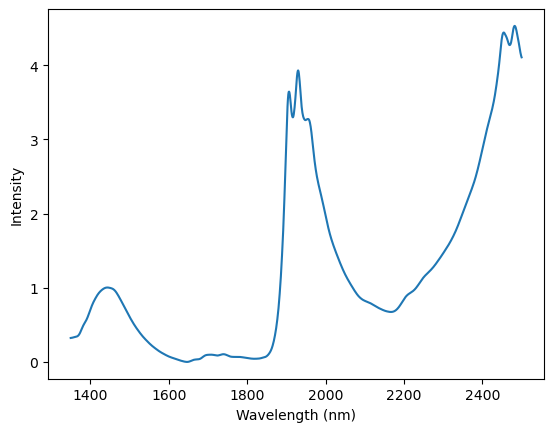

In [10]:
wavelengths = data.loc[:,'1350.0':].columns.astype(float)  
values = data.loc[6000, '1350.0':]       

plt.plot(wavelengths[wavelengths >= 1350], values)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity") 
plt.show()

In [4]:
l = data['Lactate']
u = data['Urea']
g = data['Glucose']
X = data.iloc[:,3:]

In [5]:
lactate = pd.concat([l, X], axis=1)

urea = pd.concat([u, X], axis=1)

glucose = pd.concat([g, X], axis=1)


## Just Lactate

In [29]:
urea_zero_id = data.index[data['Urea'] == 0.0].tolist()
only_lactate = lactate.iloc[urea_zero_id,:]
only_lactate['Lactate'].value_counts()

72.0     100
103.0    100
147.0    100
210.0    100
300.0    100
9.0       70
12.0      70
17.0      70
25.0      70
35.0      70
50.0      70
Name: Lactate, dtype: int64

In [15]:
only_lactate.shape

(920, 1152)

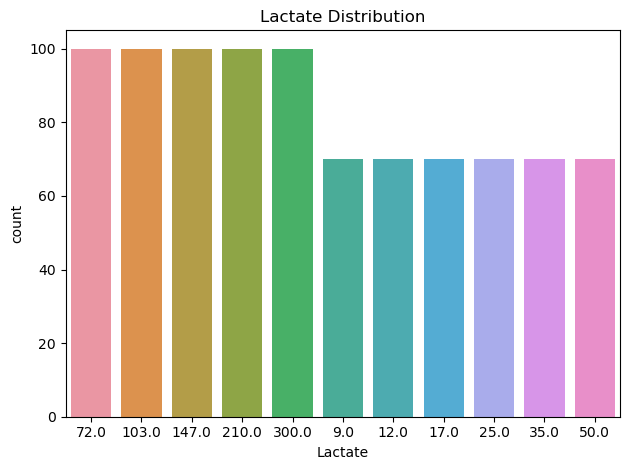

In [14]:
plt.figure()
sns.countplot(only_lactate, x='Lactate', order=only_lactate['Lactate'].value_counts().index)
plt.title(f'Lactate Distribution')
plt.tight_layout()
plt.show()

### Random Forest

In [30]:
train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

test.columns = test.columns.astype(str)
train.columns = train.columns.astype(str)

y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

scaler = StandardScaler()

normalized = scaler.fit_transform(train.iloc[:,1:].T).T
X_train = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)

In [13]:
rf = Pipeline([
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 2.393979 - train R2 0.999339 — val RMSE 1.560495 - val R2 0.999719


In [31]:
rf = Pipeline([
    ("PCA", PCA(0.95)),
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 4.867152 - train R2 0.997268 — val RMSE 6.289806 - val R2 0.995437


### CNN 

In [76]:
train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2 = train_eval_cnn(train, validation, test, epochs = 100, input_length = only_lactate.shape[1] - 1, batch_size = 16, updates = True, file_name = 'cnn_only_lact_mod.pth',earlystop = True, patience = 10)

Epoch  1 — train RMSE 88.160369 - train R2 0.103569 — val RMSE 66.287449 - val R2 0.493008
Epoch  2 — train RMSE 55.243855 - train R2 0.648004 — val RMSE 45.645992 - val R2 0.759595
Epoch  3 — train RMSE 38.106384 - train R2 0.832519 — val RMSE 34.682875 - val R2 0.861207
Epoch  4 — train RMSE 23.762203 - train R2 0.934876 — val RMSE 15.856672 - val R2 0.970989
Epoch  5 — train RMSE 16.057143 - train R2 0.970262 — val RMSE 13.319942 - val R2 0.979529
Epoch  6 — train RMSE 12.361741 - train R2 0.982375 — val RMSE 10.236125 - val R2 0.987910
Epoch  7 — train RMSE 12.629452 - train R2 0.981603 — val RMSE 8.780434 - val R2 0.991104
Epoch  8 — train RMSE 11.240475 - train R2 0.985427 — val RMSE 8.420343 - val R2 0.991819
Epoch  9 — train RMSE 12.942933 - train R2 0.980679 — val RMSE 9.854153 - val R2 0.988796
Epoch 10 — train RMSE 10.279610 - train R2 0.987812 — val RMSE 7.643517 - val R2 0.993259
Epoch 11 — train RMSE 8.933242 - train R2 0.990796 — val RMSE 8.117912 - val R2 0.992396
Epoch

### Raman-LLM

In [12]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'only_lact_mod.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 116.408601 - train R2 -0.562932 — val RMSE 104.014697 - val R2 -0.248327
Epoch  2 — train RMSE 104.909792 - train R2 -0.269410 — val RMSE 95.388805 - val R2 -0.049865
Epoch  3 — train RMSE 100.368294 - train R2 -0.161885 — val RMSE 91.538385 - val R2 0.033181
Epoch  4 — train RMSE 90.496290 - train R2 0.055436 — val RMSE 83.408712 - val R2 0.197284
Epoch  5 — train RMSE 85.293098 - train R2 0.160931 — val RMSE 72.371586 - val R2 0.395669
Epoch  6 — train RMSE 74.243315 - train R2 0.364253 — val RMSE 58.461989 - val R2 0.605646
Epoch  7 — train RMSE 65.473236 - train R2 0.505578 — val RMSE 49.005493 - val R2 0.722905
Epoch  8 — train RMSE 62.693693 - train R2 0.546667 — val RMSE 47.910130 - val R2 0.735154
Epoch  9 — train RMSE 61.540635 - train R2 0.563189 — val RMSE 43.609326 - val R2 0.780569
Epoch 10 — train RMSE 56.903024 - train R2 0.626543 — val RMSE 46.887791 - val R2 0.746336
Epoch 11 — train RMSE 57.599090 - train R2 0.617351 — val RMSE 36.755046 - val R2

#### No dropout

In [13]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'only_lact_mod_no_drop.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 113.098887 - train R2 -0.475321 — val RMSE 102.019023 - val R2 -0.200884
Epoch  2 — train RMSE 97.956275 - train R2 -0.106712 — val RMSE 95.145596 - val R2 -0.044519
Epoch  3 — train RMSE 92.136278 - train R2 0.020890 — val RMSE 93.474090 - val R2 -0.008141
Epoch  4 — train RMSE 89.535592 - train R2 0.075384 — val RMSE 88.247718 - val R2 0.101443
Epoch  5 — train RMSE 85.137584 - train R2 0.163988 — val RMSE 81.797071 - val R2 0.228005
Epoch  6 — train RMSE 79.087021 - train R2 0.278593 — val RMSE 78.264836 - val R2 0.293240
Epoch  7 — train RMSE 70.957971 - train R2 0.419272 — val RMSE 69.311050 - val R2 0.445701
Epoch  8 — train RMSE 63.434715 - train R2 0.535887 — val RMSE 58.181374 - val R2 0.609423
Epoch  9 — train RMSE 54.173105 - train R2 0.661517 — val RMSE 48.665703 - val R2 0.726734
Epoch 10 — train RMSE 47.161638 - train R2 0.743464 — val RMSE 42.540220 - val R2 0.791196
Epoch 11 — train RMSE 41.120908 - train R2 0.804973 — val RMSE 36.694953 - val R2 0

#### Adding more attention heads

In [27]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'only_lact_mod_no_drop4.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 112.765793 - train R2 -0.466644 — val RMSE 104.207708 - val R2 -0.252964
Epoch  2 — train RMSE 99.333354 - train R2 -0.138047 — val RMSE 89.768776 - val R2 0.070200
Epoch  3 — train RMSE 84.021677 - train R2 0.185760 — val RMSE 83.279084 - val R2 0.199778
Epoch  4 — train RMSE 76.000009 - train R2 0.333811 — val RMSE 70.135307 - val R2 0.432439
Epoch  5 — train RMSE 65.206451 - train R2 0.509599 — val RMSE 59.694159 - val R2 0.588848
Epoch  6 — train RMSE 55.001970 - train R2 0.651080 — val RMSE 49.230254 - val R2 0.720358
Epoch  7 — train RMSE 44.434937 - train R2 0.772271 — val RMSE 40.452027 - val R2 0.811192
Epoch  8 — train RMSE 36.184420 - train R2 0.848987 — val RMSE 34.815924 - val R2 0.860140
Epoch  9 — train RMSE 32.645984 - train R2 0.877078 — val RMSE 28.917433 - val R2 0.903515
Epoch 10 — train RMSE 28.239488 - train R2 0.908022 — val RMSE 25.410632 - val R2 0.925498
Epoch 11 — train RMSE 24.775135 - train R2 0.929205 — val RMSE 26.999093 - val R2 0.9

#### Adding more LLM layers

In [12]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'only_lact_mod_no_drop5.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 113.286912 - train R2 -0.480231 — val RMSE 104.100064 - val R2 -0.250377
Epoch  2 — train RMSE 102.961032 - train R2 -0.222688 — val RMSE 96.841963 - val R2 -0.082097
Epoch  3 — train RMSE 91.213454 - train R2 0.040406 — val RMSE 87.556382 - val R2 0.115466
Epoch  4 — train RMSE 81.347579 - train R2 0.236763 — val RMSE 77.218758 - val R2 0.312006
Epoch  5 — train RMSE 75.902540 - train R2 0.335519 — val RMSE 72.336039 - val R2 0.396262
Epoch  6 — train RMSE 70.234565 - train R2 0.431053 — val RMSE 74.577750 - val R2 0.358262
Epoch  7 — train RMSE 64.289210 - train R2 0.523299 — val RMSE 58.130342 - val R2 0.610108
Epoch  8 — train RMSE 56.959010 - train R2 0.625808 — val RMSE 56.131447 - val R2 0.636461
Epoch  9 — train RMSE 48.243661 - train R2 0.731558 — val RMSE 43.959402 - val R2 0.777032
Epoch 10 — train RMSE 41.945666 - train R2 0.797071 — val RMSE 35.761954 - val R2 0.852436
Epoch 11 — train RMSE 39.249092 - train R2 0.822324 — val RMSE 42.535612 - val R2 0

Test the best model in new data

In [87]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(only_lactate, test_size=0.2, random_state=1, stratify= only_lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("only_lact_mod_no_drop5.pth", map_location=device))

eval_model(train, test, model, task = 'regression')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE 6.505010 — Test R2 0.995126


## Lactate

In [6]:
lactate['Lactate'].value_counts()

72.0     1000
103.0    1000
210.0    1000
300.0    1000
147.0     900
9.0       700
12.0      700
17.0      700
25.0      700
35.0      700
50.0      700
Name: Lactate, dtype: int64

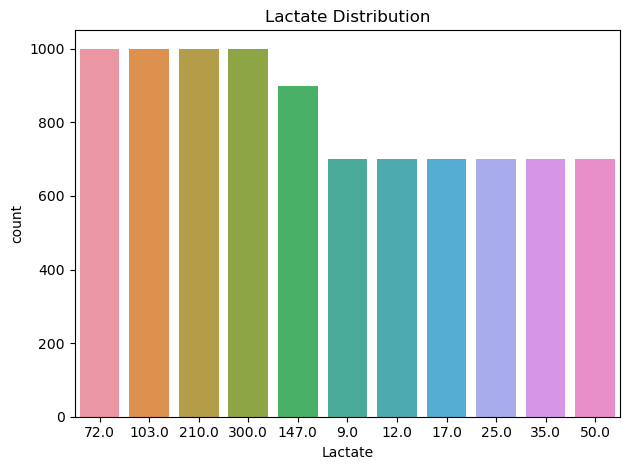

In [7]:
plt.figure()
sns.countplot(lactate, x='Lactate', order=lactate['Lactate'].value_counts().index)
plt.title(f'Lactate Distribution')
plt.tight_layout()
plt.show()

### Raman-LLM 

In [16]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'lact_mod_no_drop.pth')
#396 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 79.811719 - train R2 0.271350 — val RMSE 67.568643 - val R2 0.477753
Epoch  2 — train RMSE 59.385584 - train R2 0.596589 — val RMSE 49.101461 - val R2 0.724213
Epoch  3 — train RMSE 39.979954 - train R2 0.817160 — val RMSE 36.017030 - val R2 0.851611
Epoch  4 — train RMSE 26.322586 - train R2 0.920742 — val RMSE 23.898016 - val R2 0.934670
Epoch  5 — train RMSE 20.331206 - train R2 0.952716 — val RMSE 20.659994 - val R2 0.951175
Epoch  6 — train RMSE 17.703845 - train R2 0.964147 — val RMSE 17.983446 - val R2 0.963006
Epoch  7 — train RMSE 16.269530 - train R2 0.969721 — val RMSE 14.990267 - val R2 0.974296
Epoch  8 — train RMSE 15.250192 - train R2 0.973397 — val RMSE 13.846718 - val R2 0.978068
Epoch  9 — train RMSE 14.113859 - train R2 0.977214 — val RMSE 13.006807 - val R2 0.980648
Epoch 10 — train RMSE 13.785418 - train R2 0.978262 — val RMSE 15.759974 - val R2 0.971588
Epoch 11 — train RMSE 12.373820 - train R2 0.982486 — val RMSE 13.603900 - val R2 0.978830

#### New config

In [16]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'lact_mod_no_drop2.pth')

#296 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 79.403009 - train R2 0.278794 — val RMSE 66.252015 - val R2 0.497908
Epoch  2 — train RMSE 53.660126 - train R2 0.670626 — val RMSE 41.998436 - val R2 0.798232
Epoch  3 — train RMSE 34.371028 - train R2 0.864864 — val RMSE 26.470737 - val R2 0.919847
Epoch  4 — train RMSE 22.570458 - train R2 0.941727 — val RMSE 17.361007 - val R2 0.965523
Epoch  5 — train RMSE 16.487294 - train R2 0.968905 — val RMSE 12.294760 - val R2 0.982709
Epoch  6 — train RMSE 13.722489 - train R2 0.978460 — val RMSE 11.056341 - val R2 0.986017
Epoch  7 — train RMSE 14.352157 - train R2 0.976438 — val RMSE 9.194860 - val R2 0.990329
Epoch  8 — train RMSE 11.074020 - train R2 0.985972 — val RMSE 7.968058 - val R2 0.992737
Epoch  9 — train RMSE 11.286839 - train R2 0.985428 — val RMSE 9.319570 - val R2 0.990065
Epoch 10 — train RMSE 8.617838 - train R2 0.991505 — val RMSE 8.445947 - val R2 0.991840
Epoch 11 — train RMSE 11.568740 - train R2 0.984691 — val RMSE 19.524963 - val R2 0.956392
Epoc

Test the best model in new data

In [15]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)
train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("lact_mod_no_drop2.pth", map_location=device))

eval_model(train, test, model, task = 'regression')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE 4.658707 — Test R2 0.997518


#### No scaling at all

In [10]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'lact_mod_no_drop3.pth')
#802 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 94.623408 - train R2 -0.024194 — val RMSE 93.566130 - val R2 -0.001435
Epoch  2 — train RMSE 89.325081 - train R2 0.087292 — val RMSE 83.700159 - val R2 0.198621
Epoch  3 — train RMSE 73.965519 - train R2 0.374187 — val RMSE 79.204282 - val R2 0.282399
Epoch  4 — train RMSE 61.639269 - train R2 0.565389 — val RMSE 55.726977 - val R2 0.644764
Epoch  5 — train RMSE 52.438923 - train R2 0.685448 — val RMSE 45.812387 - val R2 0.759923
Epoch  6 — train RMSE 46.235136 - train R2 0.755472 — val RMSE 44.150834 - val R2 0.777021
Epoch  7 — train RMSE 45.660127 - train R2 0.761516 — val RMSE 38.709207 - val R2 0.828599
Epoch  8 — train RMSE 43.955442 - train R2 0.778990 — val RMSE 39.167681 - val R2 0.824515
Epoch  9 — train RMSE 43.500371 - train R2 0.783543 — val RMSE 40.434623 - val R2 0.812978
Epoch 10 — train RMSE 37.228268 - train R2 0.841463 — val RMSE 33.870469 - val R2 0.868772
Epoch 11 — train RMSE 37.960010 - train R2 0.835170 — val RMSE 54.774735 - val R2 0.6568

### Random forest

In [26]:
train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

test.columns = test.columns.astype(str)
train.columns = train.columns.astype(str)

y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

scaler = StandardScaler()

normalized = scaler.fit_transform(train.iloc[:,1:].T).T
X_train = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)

In [27]:
rf = Pipeline([
    ("PCA", PCA(0.95)),
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 4.707867 - train R2 0.997465 — val RMSE 10.820172 - val R2 0.986608


In [35]:
rf = Pipeline([
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 2.374869 - train R2 0.999355 — val RMSE 5.193734 - val R2 0.996914


### CNN

In [75]:
train, test = model_selection.train_test_split(lactate, test_size=0.2, random_state=1, stratify= lactate['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2 = train_eval_cnn(train, validation, test, epochs = 100, input_length = only_lactate.shape[1] - 1, batch_size = 16, updates = True, file_name = 'cnn_lact_mod.pth',earlystop = True, patience = 10)

Epoch  1 — train RMSE 44.941137 - train R2 0.768967 — val RMSE 27.448066 - val R2 0.913819
Epoch  2 — train RMSE 15.863584 - train R2 0.971214 — val RMSE 14.462083 - val R2 0.976075
Epoch  3 — train RMSE 11.954052 - train R2 0.983654 — val RMSE 11.020919 - val R2 0.986106
Epoch  4 — train RMSE 9.851839 - train R2 0.988898 — val RMSE 10.406749 - val R2 0.987612


Epoch  5 — train RMSE 8.814933 - train R2 0.991112 — val RMSE 6.885148 - val R2 0.994577
Epoch  6 — train RMSE 7.496566 - train R2 0.993572 — val RMSE 11.229078 - val R2 0.985576
Epoch  7 — train RMSE 7.516940 - train R2 0.993536 — val RMSE 8.550665 - val R2 0.991637
Epoch  8 — train RMSE 7.344263 - train R2 0.993830 — val RMSE 6.159082 - val R2 0.995661
Epoch  9 — train RMSE 6.440320 - train R2 0.995255 — val RMSE 5.820034 - val R2 0.996125
Epoch 10 — train RMSE 6.230367 - train R2 0.995560 — val RMSE 6.623362 - val R2 0.994982
Epoch 11 — train RMSE 5.926058 - train R2 0.995983 — val RMSE 6.149244 - val R2 0.995675
Epoch 12 — train RMSE 6.185272 - train R2 0.995624 — val RMSE 5.340538 - val R2 0.996737
Epoch 13 — train RMSE 5.670392 - train R2 0.996322 — val RMSE 4.878315 - val R2 0.997278
Epoch 14 — train RMSE 5.607829 - train R2 0.996403 — val RMSE 7.940692 - val R2 0.992787
Epoch 15 — train RMSE 5.236745 - train R2 0.996863 — val RMSE 6.244273 - val R2 0.995540
Epoch 16 — train RMS

## Urea

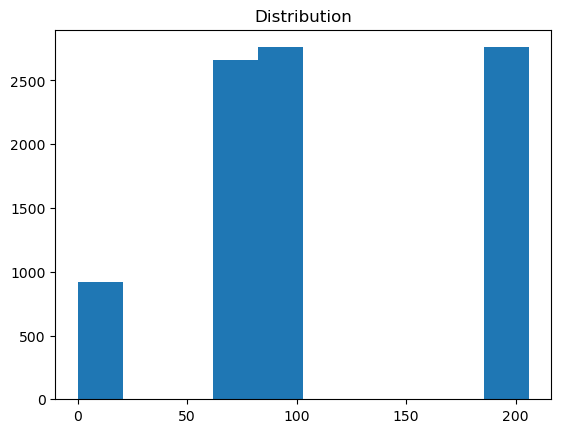

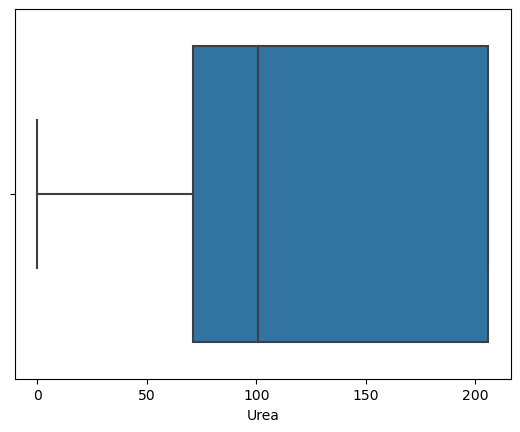

In [16]:
plt.figure()
plt.hist(urea['Urea'])
plt.title(f'Distribution')
plt.show()

import seaborn as sns
plt.figure()
sns.boxplot(data=urea, x='Urea')
plt.show()

In [17]:
urea['Urea'].value_counts()

101.0    2760
206.0    2760
71.0     2660
0.0       920
Name: Urea, dtype: int64

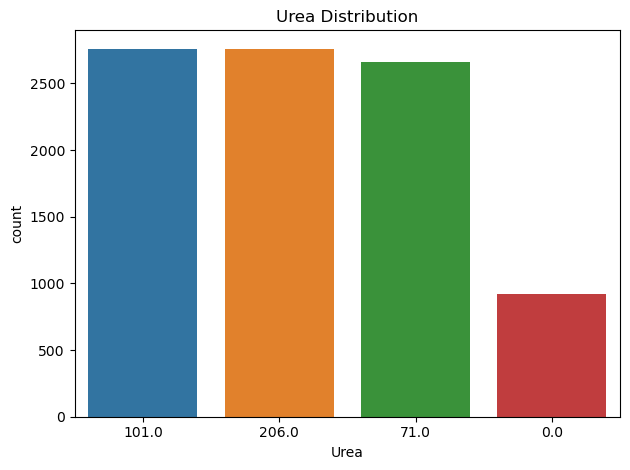

In [18]:
plt.figure()
sns.countplot(urea, x='Urea', order=urea['Urea'].value_counts().index)
plt.title(f'Urea Distribution')
plt.tight_layout()
plt.show()

### LLM model

In [20]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of urea concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(urea, test_size=0.2, random_state=1, stratify= urea['Urea'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Urea'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'urea_mod_no_drop.pth')
#555 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 74.534295 - train R2 -0.242050 — val RMSE 61.020512 - val R2 0.167473
Epoch  2 — train RMSE 52.794917 - train R2 0.376824 — val RMSE 46.123899 - val R2 0.524337
Epoch  3 — train RMSE 43.540096 - train R2 0.576157 — val RMSE 41.482995 - val R2 0.615243
Epoch  4 — train RMSE 40.006506 - train R2 0.642161 — val RMSE 39.218316 - val R2 0.656106
Epoch  5 — train RMSE 37.523564 - train R2 0.685200 — val RMSE 36.761238 - val R2 0.697847
Epoch  6 — train RMSE 35.546450 - train R2 0.717500 — val RMSE 33.538481 - val R2 0.748502
Epoch  7 — train RMSE 33.318855 - train R2 0.751797 — val RMSE 34.198209 - val R2 0.738511
Epoch  8 — train RMSE 32.257167 - train R2 0.767363 — val RMSE 30.886777 - val R2 0.786699
Epoch  9 — train RMSE 30.545808 - train R2 0.791392 — val RMSE 31.029978 - val R2 0.784717
Epoch 10 — train RMSE 29.048264 - train R2 0.811346 — val RMSE 29.034352 - val R2 0.811517
Epoch 11 — train RMSE 27.795871 - train R2 0.827263 — val RMSE 27.363963 - val R2 0.83258

#### New config

In [17]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of urea concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(urea, test_size=0.2, random_state=1, stratify= urea['Urea'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Urea'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True,  file_name = 'urea_mod_no_drop2.pth')
#709 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 73.440564 - train R2 -0.205864 — val RMSE 59.246606 - val R2 0.215173
Epoch  2 — train RMSE 51.113961 - train R2 0.415875 — val RMSE 43.472513 - val R2 0.577452
Epoch  3 — train RMSE 39.623354 - train R2 0.648983 — val RMSE 34.504255 - val R2 0.733810
Epoch  4 — train RMSE 33.956859 - train R2 0.742201 — val RMSE 29.743497 - val R2 0.802198
Epoch  5 — train RMSE 29.614709 - train R2 0.803916 — val RMSE 27.031305 - val R2 0.836627
Epoch  6 — train RMSE 26.960487 - train R2 0.837490 — val RMSE 28.222257 - val R2 0.821914
Epoch  7 — train RMSE 24.989853 - train R2 0.860378 — val RMSE 23.010174 - val R2 0.881618
Epoch  8 — train RMSE 22.833595 - train R2 0.883433 — val RMSE 21.320126 - val R2 0.898369
Epoch  9 — train RMSE 21.823595 - train R2 0.893517 — val RMSE 21.478387 - val R2 0.896855
Epoch 10 — train RMSE 19.764691 - train R2 0.912661 — val RMSE 18.536978 - val R2 0.923171
Epoch 11 — train RMSE 18.788357 - train R2 0.921077 — val RMSE 18.870643 - val R2 0.92038

Test best model in new data

In [21]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of urea concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)
train, test = model_selection.train_test_split(urea, test_size=0.2, random_state=1, stratify= urea['Urea'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['Urea'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("urea_mod_no_drop2.pth", map_location=device))

eval_model(train, test, model, task = 'regression')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test RMSE 4.861285 — Test R2 0.994588


### Random Forest

In [22]:
train, test = model_selection.train_test_split(urea, test_size=0.2, random_state=1, stratify= urea['Urea'])

test.columns = test.columns.astype(str)
train.columns = train.columns.astype(str)

y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

scaler = StandardScaler()

normalized = scaler.fit_transform(train.iloc[:,1:].T).T
X_train = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)

In [ ]:
rf = Pipeline([
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 3.028133 - train R2 0.997950 — val RMSE 5.811401 - val R2 0.992449


In [25]:
rf = Pipeline([
    ("PCA", PCA(0.95)),
    ("RandomForest", RandomForestRegressor())])

rf.fit(X_train, y_train)

train_r2 = rf.score(X_train, y_train)

val_r2 = rf.score(X_test, y_test)
train_rmse = np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))
val_rmse = np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
print(f"Results — train RMSE {train_rmse:.6f} - train R2 {train_r2:.6f} — val RMSE {val_rmse:.6f} - val R2 {val_r2:.6f}")

Results — train RMSE 5.224305 - train R2 0.993898 — val RMSE 13.782463 - val R2 0.957530


### CNN

In [78]:
train, test = model_selection.train_test_split(urea, test_size=0.1, random_state=1, stratify= urea['Urea'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Urea'])

model ,train_rmse, train_r2, val_rmse, val_r2 = train_eval_cnn(train, validation, test, epochs = 100, input_length = only_lactate.shape[1] - 1, batch_size = 16, updates = True, file_name = 'cnn_urea_mod.pth',earlystop = True, patience = 10)

Epoch  1 — train RMSE 45.390867 - train R2 0.539374 — val RMSE 33.043974 - val R2 0.755778
Epoch  2 — train RMSE 30.457089 - train R2 0.792610 — val RMSE 27.880427 - val R2 0.826140


Epoch  3 — train RMSE 25.100078 - train R2 0.859149 — val RMSE 21.785101 - val R2 0.893850
Epoch  4 — train RMSE 21.762391 - train R2 0.894118 — val RMSE 20.351969 - val R2 0.907357
Epoch  5 — train RMSE 19.666300 - train R2 0.913532 — val RMSE 18.764564 - val R2 0.921245
Epoch  6 — train RMSE 17.435821 - train R2 0.932033 — val RMSE 17.574731 - val R2 0.930916
Epoch  7 — train RMSE 16.097749 - train R2 0.942065 — val RMSE 15.061029 - val R2 0.949265
Epoch  8 — train RMSE 15.137381 - train R2 0.948771 — val RMSE 14.267026 - val R2 0.954473
Epoch  9 — train RMSE 14.592315 - train R2 0.952394 — val RMSE 16.900982 - val R2 0.936111
Epoch 10 — train RMSE 13.934576 - train R2 0.956589 — val RMSE 13.223215 - val R2 0.960891
Epoch 11 — train RMSE 12.543728 - train R2 0.964823 — val RMSE 12.965565 - val R2 0.962400
Epoch 12 — train RMSE 12.832590 - train R2 0.963184 — val RMSE 11.331348 - val R2 0.971281
Epoch 13 — train RMSE 12.529682 - train R2 0.964901 — val RMSE 11.453435 - val R2 0.970659

## Preprocessed

In [11]:
WindowLength = 41
X_deriv = savgol_filter(X, window_length = WindowLength, polyorder = 3, deriv = 2, mode='nearest')

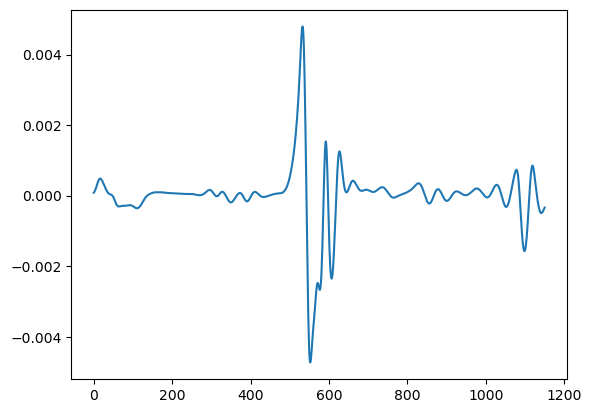

In [12]:
plt.plot(X_deriv[0])
plt.show()

### Second derivative

In [13]:
X_preprocessed1 = pd.DataFrame(data=X_deriv, index=X.index, columns=X.columns)
X_preprocessed1

,1350.0,1351.0,1352.0,1353.0,1354.0,1355.0,1356.0,1357.0,1358.0,1359.0,...,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
0,0.000084,0.000099,0.000117,0.000139,0.000165,0.000194,0.000227,0.000261,0.000297,0.000333,...,-0.000494,-0.000493,-0.000485,-0.000472,-0.000455,-0.000434,-0.000412,-0.000388,-0.000364,-0.000339
1,0.000085,0.000099,0.000118,0.000140,0.000165,0.000195,0.000227,0.000261,0.000297,0.000333,...,-0.000519,-0.000527,-0.000528,-0.000523,-0.000512,-0.000495,-0.000474,-0.000447,-0.000416,-0.000381
2,0.000084,0.000099,0.000117,0.000139,0.000165,0.000194,0.000227,0.000261,0.000297,0.000333,...,-0.000582,-0.000603,-0.000613,-0.000614,-0.000608,-0.000596,-0.000578,-0.000556,-0.000531,-0.000502
3,0.000084,0.000099,0.000118,0.000140,0.000165,0.000195,0.000227,0.000262,0.000297,0.000333,...,-0.000498,-0.000498,-0.000490,-0.000475,-0.000455,-0.000433,-0.000409,-0.000385,-0.000362,-0.000340
4,0.000084,0.000099,0.000118,0.000140,0.000165,0.000195,0.000227,0.000262,0.000297,0.000333,...,-0.000529,-0.000513,-0.000489,-0.000459,-0.000424,-0.000388,-0.000351,-0.000315,-0.000281,-0.000249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9095,0.000080,0.000091,0.000104,0.000121,0.000141,0.000164,0.000191,0.000220,0.000250,0.000281,...,-0.000308,-0.000381,-0.000447,-0.000506,-0.000556,-0.000598,-0.000630,-0.000652,-0.000664,-0.000665
9096,0.000080,0.000091,0.000104,0.000121,0.000141,0.000164,0.000191,0.000220,0.000250,0.000281,...,-0.000765,-0.000775,-0.000771,-0.000754,-0.000726,-0.000687,-0.000639,-0.000583,-0.000520,-0.000451
9097,0.000080,0.000091,0.000104,0.000121,0.000141,0.000164,0.000191,0.000220,0.000250,0.000282,...,-0.000534,-0.000577,-0.000608,-0.000629,-0.000640,-0.000639,-0.000626,-0.000603,-0.000569,-0.000525
9098,0.000080,0.000091,0.000104,0.000121,0.000141,0.000164,0.000191,0.000220,0.000250,0.000281,...,-0.000779,-0.000798,-0.000803,-0.000794,-0.000772,-0.000740,-0.000697,-0.000645,-0.000584,-0.000517


In [14]:
lactate_p = pd.concat([l, X_preprocessed1], axis=1)

urea_p = pd.concat([u, X_preprocessed1], axis=1)

glucose_p = pd.concat([g, X_preprocessed1], axis=1)

#### Lactate

In [64]:
lactate_p.shape

(9100, 1152)

### Second derivative, cropped and standarized data

In [15]:
U_filter = np.ones(np.shape(X_deriv))

''' Applying the filter to the two wavelength regions
# Wavelength 1350 - 2499 nm - indices 0 - 1150
# Regions of wavelength being zeroed. 
## R1 - 1380-1480 nm - 30:130
## R2 - 1850 - 2050 nm - 500:700
'''
U_filter[:,30:150] = 0
U_filter[:,500:700] = 0

#Apply filter
X_filtered = X_deriv*U_filter

#print(X_test*U_test)

In [16]:
np.set_printoptions(threshold=np.inf)


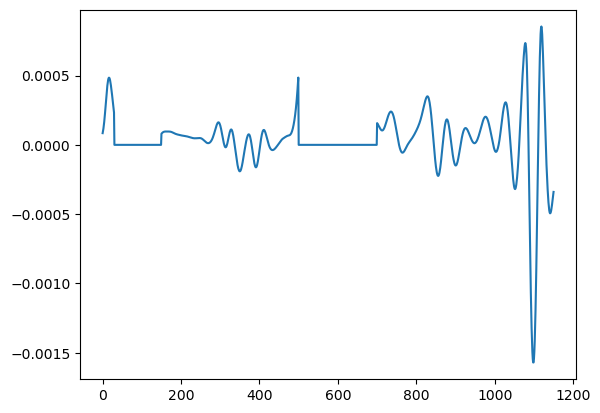

In [17]:
plt.plot(X_filtered[0])
plt.show()

In [18]:
pd.set_option('display.max_columns', None)

X_preprocessed2 = pd.DataFrame(data=X_filtered, index=X.index, columns=X.columns)
X_preprocessed2

1350.0    1351.0    1352.0    1353.0    1354.0    1355.0    1356.0  \
0     0.000084  0.000099  0.000117  0.000139  0.000165  0.000194  0.000227   
1     0.000085  0.000099  0.000118  0.000140  0.000165  0.000195  0.000227   
2     0.000084  0.000099  0.000117  0.000139  0.000165  0.000194  0.000227   
3     0.000084  0.000099  0.000118  0.000140  0.000165  0.000195  0.000227   
4     0.000084  0.000099  0.000118  0.000140  0.000165  0.000195  0.000227   
...        ...       ...       ...       ...       ...       ...       ...   
9095  0.000080  0.000091  0.000104  0.000121  0.000141  0.000164  0.000191   
9096  0.000080  0.000091  0.000104  0.000121  0.000141  0.000164  0.000191   
9097  0.000080  0.000091  0.000104  0.000121  0.000141  0.000164  0.000191   
9098  0.000080  0.000091  0.000104  0.000121  0.000141  0.000164  0.000191   
9099  0.000080  0.000091  0.000104  0.000121  0.000141  0.000164  0.000191   

        1357.0    1358.0    1359.0    1360.0    1361.0    1362.0    1363.0  \
0     0.000261  0.000297  0.000333  0.000367  0.000399  0.000427  0.000450   
1     0.000261  0.000297  0.000333  0.000367  0.000399  0.000427  0.000451   
2     0.000261  0.000297  0.000333  0.000367  0.000399  0.000427  0.000451   
3     0.000262  0.000297  0.000333  0.000368  0.000400  0.000428  0.000451   
4     0.000262  0.000297  0.000333  0.000368  0.000400  0.000428  0.000451   
...        ...       ...       ...       ...       ...       ...       ...   
9095  0.000220  0.000250  0.000281  0.000312  0.000341  0.000368  0.000391   
9096  0.000220  0.000250  0.000281  0.000312  0.000342  0.000368  0.000391   
9097  0.000220  0.000250  0.000282  0.000313  0.000342  0.000368  0.000391   
9098  0.000220  0.000250  0.000281  0.000312  0.000342  0.000368  0.000391   
9099  0.000220  0.000250  0.000282  0.000312  0.000342  0.000368  0.000391   

        1364.0    1365.0    1366.0    1367.0    1368.0    1369.0    1370.0  \
0     0.000468  0.000479  0.000484  0.000483  0.000477  0.000465  0.000449   
1     0.000468  0.000480  0.000485  0.000483  0.000477  0.000465  0.000449   
2     0.000468  0.000480  0.000485  0.000484  0.000477  0.000465  0.000449   
3     0.000469  0.000480  0.000485  0.000484  0.000477  0.000465  0.000450   
4     0.000469  0.000480  0.000485  0.000484  0.000477  0.000466  0.000450   
...        ...       ...       ...       ...       ...       ...       ...   
9095  0.000409  0.000423  0.000431  0.000434  0.000432  0.000427  0.000418   
9096  0.000409  0.000423  0.000431  0.000434  0.000433  0.000427  0.000418   
9097  0.000410  0.000423  0.000431  0.000434  0.000433  0.000427  0.000418   
9098  0.000409  0.000423  0.000431  0.000434  0.000433  0.000427  0.000419   
9099  0.000409  0.000423  0.000431  0.000434  0.000432  0.000427  0.000418   

        1371.0    1372.0    1373.0    1374.0    1375.0    1376.0    1377.0  \
0     0.000430  0.000409  0.000386  0.000361  0.000336  0.000311  0.000285   
1     0.000430  0.000409  0.000386  0.000361  0.000336  0.000310  0.000284   
2     0.000431  0.000409  0.000386  0.000362  0.000336  0.000311  0.000285   
3     0.000431  0.000410  0.000386  0.000362  0.000337  0.000311  0.000285   
4     0.000431  0.000410  0.000386  0.000362  0.000337  0.000311  0.000285   
...        ...       ...       ...       ...       ...       ...       ...   
9095  0.000407  0.000394  0.000380  0.000364  0.000348  0.000331  0.000313   
9096  0.000407  0.000394  0.000380  0.000364  0.000348  0.000331  0.000313   
9097  0.000407  0.000394  0.000380  0.000364  0.000348  0.000331  0.000313   
9098  0.000408  0.000395  0.000380  0.000364  0.000348  0.000331  0.000313   
9099  0.000407  0.000394  0.000380  0.000364  0.000348  0.000331  0.000313   

        1378.0    1379.0  1380.0  1381.0  1382.0  1383.0  1384.0  1385.0  \
0     0.000259  0.000233     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.000258  0.000233     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.000259  0.000234     0.0

In [19]:
lactate_p2 = pd.concat([l, X_preprocessed2], axis=1)

urea_p2 = pd.concat([u, X_preprocessed2], axis=1)

glucose_p2 = pd.concat([g, X_preprocessed2], axis=1)

#### Lactate

In [69]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate_p2, test_size=0.60, random_state=1, stratify= lactate_p2['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True)

#190 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 105.972152 - train R2 -0.284605 — val RMSE 89.899938 - val R2 0.075505
Epoch  2 — train RMSE 78.823093 - train R2 0.289290 — val RMSE 52.672361 - val R2 0.682641
Epoch  3 — train RMSE 62.123901 - train R2 0.558528 — val RMSE 38.160685 - val R2 0.833422
Epoch  4 — train RMSE 53.707413 - train R2 0.670045 — val RMSE 32.672950 - val R2 0.877887
Epoch  5 — train RMSE 55.510691 - train R2 0.647516 — val RMSE 32.754151 - val R2 0.877279
Epoch  6 — train RMSE 51.092537 - train R2 0.701392 — val RMSE 30.519489 - val R2 0.893453
Epoch  7 — train RMSE 50.082986 - train R2 0.713077 — val RMSE 28.641379 - val R2 0.906163
Epoch  8 — train RMSE 48.585265 - train R2 0.729981 — val RMSE 24.354581 - val R2 0.932150
Epoch  9 — train RMSE 46.142823 - train R2 0.756447 — val RMSE 24.196562 - val R2 0.933028
Epoch 10 — train RMSE 49.784915 - train R2 0.716481 — val RMSE 23.344547 - val R2 0.937661
Epoch 11 — train RMSE 48.660848 - train R2 0.729140 — val RMSE 23.646053 - val R2 0.9360

### Delete wavelengths instead of making them zero

In [20]:
r1 = X_preprocessed2.iloc[:, 30:151].columns
r2 = X_preprocessed2.iloc[:, 500:701].columns
cols_del = r1.union(r2)

X_preprocessed3 = X_preprocessed2.drop(columns=cols_del)

lactate_p = pd.concat([l, X_preprocessed3], axis=1)

urea_p = pd.concat([u, X_preprocessed3], axis=1)

glucose_p = pd.concat([g, X_preprocessed3], axis=1)

In [21]:
lactate_p.shape

(9100, 830)

#### Lactate

##### Raman-LLM

In [26]:
configs = Details(
    pred_len = 1,      
    seq_len  = 830,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0.1,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate_p, test_size=0.60, random_state=1, stratify= lactate_p['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 100, 8, True, True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 105.342959 - train R2 -0.269396 — val RMSE 82.362508 - val R2 0.224030
Epoch  2 — train RMSE 71.060860 - train R2 0.422374 — val RMSE 47.857305 - val R2 0.738012
Epoch  3 — train RMSE 60.188034 - train R2 0.585613 — val RMSE 34.240073 - val R2 0.865892
Epoch  4 — train RMSE 56.929743 - train R2 0.629265 — val RMSE 34.268764 - val R2 0.865667
Epoch  5 — train RMSE 51.119463 - train R2 0.701078 — val RMSE 28.876328 - val R2 0.904617
Epoch  6 — train RMSE 49.175660 - train R2 0.723378 — val RMSE 26.754363 - val R2 0.918121
Epoch  7 — train RMSE 48.154339 - train R2 0.734749 — val RMSE 24.352355 - val R2 0.932163
Epoch  8 — train RMSE 47.765049 - train R2 0.739021 — val RMSE 27.233359 - val R2 0.915162
Epoch  9 — train RMSE 46.787481 - train R2 0.749594 — val RMSE 25.985484 - val R2 0.922759
Epoch 10 — train RMSE 48.927752 - train R2 0.726160 — val RMSE 20.615042 - val R2 0.951387
Epoch 11 — train RMSE 49.339633 - train R2 0.721531 — val RMSE 20.691348 - val R2 0.9510

In [18]:
configs = Details(
    pred_len = 1,      
    seq_len  = 830,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 4,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 2,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate_p, test_size=0.60, random_state=1, stratify= lactate_p['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 200, 8, True, True, file_name = 'lact_p2_mod_no_drop.pth')
#328 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 94.848719 - train R2 -0.029079 — val RMSE 67.361629 - val R2 0.480948
Epoch  2 — train RMSE 56.606810 - train R2 0.633458 — val RMSE 48.528425 - val R2 0.730612
Epoch  3 — train RMSE 40.979492 - train R2 0.807904 — val RMSE 36.589166 - val R2 0.846859
Epoch  4 — train RMSE 33.866801 - train R2 0.868800 — val RMSE 32.016217 - val R2 0.882747
Epoch  5 — train RMSE 29.485309 - train R2 0.900552 — val RMSE 29.583759 - val R2 0.899887
Epoch  6 — train RMSE 26.141644 - train R2 0.921828 — val RMSE 23.148846 - val R2 0.938702
Epoch  7 — train RMSE 24.153972 - train R2 0.933264 — val RMSE 22.107947 - val R2 0.944091
Epoch  8 — train RMSE 21.691807 - train R2 0.946176 — val RMSE 19.159338 - val R2 0.958010
Epoch  9 — train RMSE 19.773687 - train R2 0.955274 — val RMSE 17.691915 - val R2 0.964196
Epoch 10 — train RMSE 18.905161 - train R2 0.959117 — val RMSE 15.838331 - val R2 0.971305
Epoch 11 — train RMSE 17.780870 - train R2 0.963835 — val RMSE 14.558109 - val R2 0.97575

In [24]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate_p, test_size=0.60, random_state=1, stratify= lactate_p['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

model ,train_rmse, train_r2, val_rmse, val_r2, stand  = train_model(configs, train, validation, 200, 8, True, True, file_name = 'lact_p2_mod_no_drop2.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train RMSE 98.071674 - train R2 -0.100203 — val RMSE 73.949527 - val R2 0.374458
Epoch  2 — train RMSE 59.735154 - train R2 0.591826 — val RMSE 47.441582 - val R2 0.742543
Epoch  3 — train RMSE 42.770938 - train R2 0.790741 — val RMSE 37.249879 - val R2 0.841279
Epoch  4 — train RMSE 34.426452 - train R2 0.864428 — val RMSE 28.311322 - val R2 0.908313
Epoch  5 — train RMSE 27.642368 - train R2 0.912595 — val RMSE 24.047350 - val R2 0.933851
Epoch  6 — train RMSE 22.919628 - train R2 0.939910 — val RMSE 23.028963 - val R2 0.939336
Epoch  7 — train RMSE 19.829816 - train R2 0.955020 — val RMSE 20.043205 - val R2 0.954046
Epoch  8 — train RMSE 18.490276 - train R2 0.960891 — val RMSE 15.072177 - val R2 0.974014
Epoch  9 — train RMSE 15.702089 - train R2 0.971797 — val RMSE 13.877261 - val R2 0.977971
Epoch 10 — train RMSE 14.765299 - train R2 0.975062 — val RMSE 15.324919 - val R2 0.973135
Epoch 11 — train RMSE 13.995301 - train R2 0.977595 — val RMSE 11.313243 - val R2 0.98535

In [25]:
configs = Details(
    pred_len = 1,      
    seq_len  = 1151,
    d_ff = 32,
    patch_len= 24, 
    stride = 16, 
    llm_layers = 6,
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements of lactate concentration in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the concentration given the different wavelengths " ,
    dropout = 0,
    n_heads = 8,
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(lactate_p, test_size=0.60, random_state=1, stratify= lactate_p['Lactate'])

train, validation = model_selection.train_test_split(train, test_size=0.1, random_state=1, stratify= train['Lactate'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("lact_p2_mod_no_drop2.pth", map_location=device))

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

In [26]:
eval_model(train, test,model, task = 'regression')

Test RMSE 4.801358 — Test R2 0.997312


# Classification

## Cancer

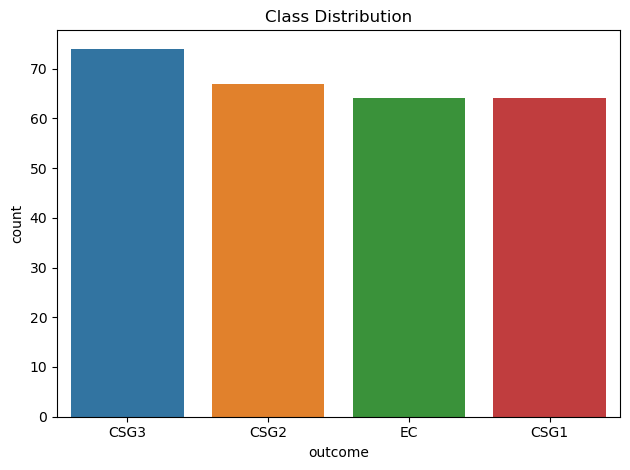

In [33]:
cancer = pd.read_csv('Training_data_Italian.csv')
del cancer['Unnamed: 0']
cancer = cancer[['outcome'] + list(cancer.columns[:-1])]
cancer['outcome'].replace(['FHL', 'AMC', 'BN', 'GD'],['EC', 'CSG1', 'CSG2', 'CSG3'], inplace=True)
plt.figure()
sns.countplot(cancer, x='outcome', order=cancer['outcome'].value_counts().index)
plt.title(f'Class Distribution')
plt.tight_layout()
plt.show()

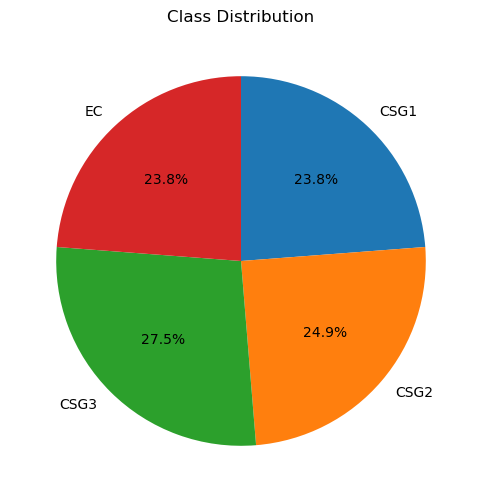

In [34]:
counts = cancer['outcome'].value_counts().sort_index()  
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',   
    startangle=90,       
    counterclock=False   
)
plt.title('Class Distribution')
plt.show()

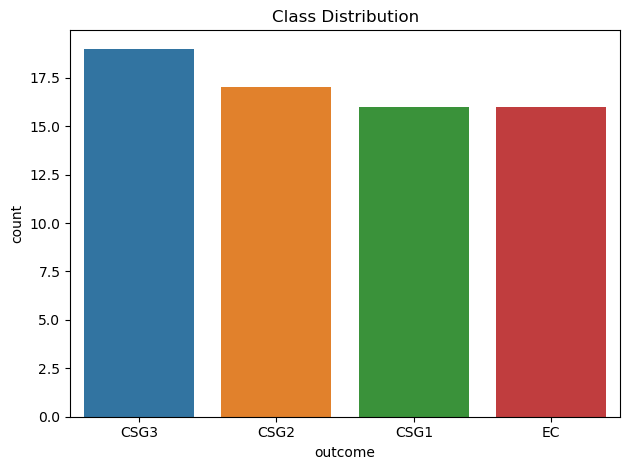

In [35]:
test = pd.read_csv('Testing_data_Italian.csv')
del test['Unnamed: 0']
test = test[['outcome'] + list(test.columns[:-1])]
test['outcome'].replace(['FHL', 'AMC', 'BN', 'GD'],['EC', 'CSG1', 'CSG2', 'CSG3'], inplace=True)
plt.figure()
sns.countplot(test, x='outcome', order=test['outcome'].value_counts().index)
plt.title(f'Class Distribution')
plt.tight_layout()
plt.show()

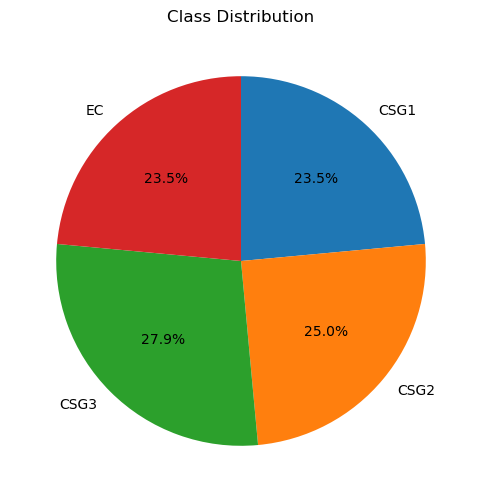

In [36]:
counts = test['outcome'].value_counts().sort_index()  
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',   
    startangle=90,     
    counterclock=False   
)
plt.title('Class Distribution')
plt.show()

In [37]:
cancer = pd.read_csv('Training_data_Italian.csv')
del cancer['Unnamed: 0']
cancer = cancer[['outcome'] + list(cancer.columns[:-1])]
le = LabelEncoder()
cancer['outcome'] = le.fit_transform(cancer['outcome'])
cancer

,outcome,399.196173,401.124639,403.053106,404.981573,406.91004,408.838507,410.766973,412.69544,414.623907,...,1783.83533,1785.7638,1787.69227,1789.62073,1791.5492,1793.47767,1795.40613,1797.3346,1799.26307,1801.19153
0,3,505.515961,429.792633,442.056671,503.923248,561.752869,569.737793,518.432251,522.847656,549.391357,...,239.627380,213.689026,197.979660,181.284073,266.008698,243.553192,183.262085,182.584747,201.362274,167.707855
1,2,862.735352,1257.182860,1079.357910,1334.693730,1643.421630,1639.412110,1437.808590,1631.328370,1635.983150,...,819.722778,745.088806,715.143005,969.721924,394.866150,669.154175,550.076294,681.312378,639.139282,291.460938
2,0,-150.525482,-167.931763,-110.162025,-92.607994,-116.657005,-109.733025,3.959946,-39.254051,-36.040154,...,-120.388206,-108.129372,-119.814186,-204.408356,-63.430839,-12.132538,3.998680,1.615150,174.106812,26.561195
3,2,213.028732,213.095520,224.707001,223.211304,233.210297,271.803040,326.114319,340.944275,306.199188,...,112.615479,113.849823,100.284653,81.723885,137.862061,117.423050,83.368675,31.846382,105.064209,139.783569
4,3,1183.171390,1121.977050,1159.223390,1265.475830,1319.099730,1344.597050,1488.174190,1338.122560,1384.080080,...,188.364594,202.664902,185.910187,187.258728,202.907410,180.061676,204.917358,162.099548,160.202332,194.598831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,0,116.517418,89.226669,144.149017,212.174286,203.939697,156.757690,212.084579,157.982330,175.348022,...,-44.818634,34.807320,-34.518677,-115.108688,-89.549851,-26.099594,-0.635860,-231.556229,-120.877533,-79.159164
265,2,1001.496770,923.082031,1222.555910,1269.627440,1468.851070,1744.580810,1411.702150,1462.815670,1431.325930,...,717.431519,829.128601,739.284668,806.189026,951.298401,750.525940,820.183838,766.859131,1096.494260,726.897644
266,0,708.721436,657.105225,703.090759,833.595886,896.817444,868.490662,893.127991,958.369385,997.086792,...,590.589233,626.296387,610.929077,558.473511,571.249695,506.676880,593.622742,581.466553,531.453369,592.837463
267,3,246.487213,244.675598,244.788330,310.309296,350.590332,341.414337,358.449921,310.393860,305.850067,...,65.794098,61.649521,83.493576,134.336029,135.778336,141.321121,95.968979,125.428558,71.864761,117.960907


In [38]:
test = pd.read_csv('Testing_data_Italian.csv')
del test['Unnamed: 0']
test = test[['outcome'] + list(test.columns[:-1])]
le = LabelEncoder()
test['outcome'] = le.fit_transform(test['outcome'])

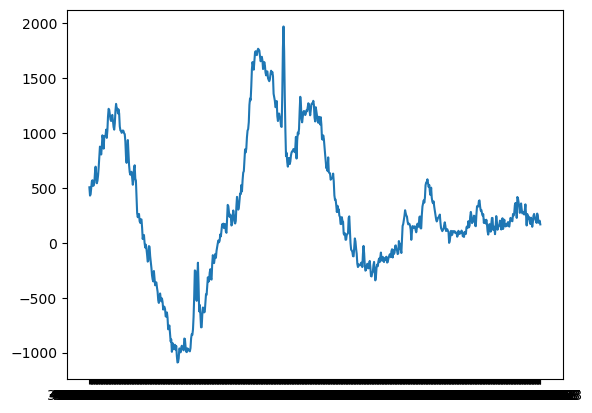

In [9]:
plt.plot(cancer.iloc[0,1:])
plt.show()

In [10]:
cancer['outcome'].value_counts()/269

3    0.275093
1    0.249071
2    0.237918
0    0.237918
Name: outcome, dtype: float64

### Raman-LLM

In [94]:
configs = Details(
    task = 'classification',
    pred_len = 4,      
    seq_len  = 728,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the classify each spectra given the different wavelengths " ,
    dropout = 0, 
    n_heads = 8, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, validation = model_selection.train_test_split(cancer, test_size=0.1, random_state=1, stratify= cancer['outcome'])

model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 100, 8, True, True, file_name = 'class_model_cancer_no_drop2.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train Accuracy : 0.297521 - train F1 0.289858 — val Accuracy 0.407407 - val F1 0.263808
Epoch  2 — train Accuracy : 0.243802 - train F1 0.241481 — val Accuracy 0.407407 - val F1 0.282119
Epoch  3 — train Accuracy : 0.289256 - train F1 0.286967 — val Accuracy 0.666667 - val F1 0.603229
Epoch  4 — train Accuracy : 0.690083 - train F1 0.689746 — val Accuracy 0.851852 - val F1 0.845213
Epoch  5 — train Accuracy : 0.863636 - train F1 0.862514 — val Accuracy 0.851852 - val F1 0.845213
Epoch  6 — train Accuracy : 0.983471 - train F1 0.983461 — val Accuracy 0.962963 - val F1 0.962628
Epoch  7 — train Accuracy : 0.975207 - train F1 0.975202 — val Accuracy 0.962963 - val F1 0.962628
Epoch  8 — train Accuracy : 0.995868 - train F1 0.995867 — val Accuracy 0.962963 - val F1 0.962628
Epoch  9 — train Accuracy : 1.000000 - train F1 1.000000 — val Accuracy 0.962963 - val F1 0.962628
Epoch 10 — train Accuracy : 1.000000 - train F1 1.000000 — val Accuracy 0.962963 - val F1 0.962628
Epoch 11 —

#### Add small dropout

In [10]:
configs = Details(
    task = 'classification',
    pred_len = 4,      
    seq_len  = 728,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the classify each spectra given the different wavelengths " ,
    dropout = 0.05, 
    n_heads = 8, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, validation = model_selection.train_test_split(cancer, test_size=0.1, random_state=1, stratify= cancer['outcome'])

model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 100, 8, True, True, file_name = 'class_model_cancer_small_drop.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train Accuracy : 0.252066 - train F1 0.249506 — val Accuracy 0.222222 - val F1 0.083333
Epoch  2 — train Accuracy : 0.268595 - train F1 0.269014 — val Accuracy 0.481481 - val F1 0.375857
Epoch  3 — train Accuracy : 0.644628 - train F1 0.644418 — val Accuracy 0.777778 - val F1 0.767431
Epoch  4 — train Accuracy : 0.809917 - train F1 0.809189 — val Accuracy 0.925926 - val F1 0.923868
Epoch  5 — train Accuracy : 0.925620 - train F1 0.925195 — val Accuracy 0.888889 - val F1 0.882509
Epoch  6 — train Accuracy : 0.950413 - train F1 0.950400 — val Accuracy 0.962963 - val F1 0.962628
Epoch  7 — train Accuracy : 0.962810 - train F1 0.962810 — val Accuracy 0.962963 - val F1 0.962628
Epoch  8 — train Accuracy : 0.983471 - train F1 0.983441 — val Accuracy 0.962963 - val F1 0.962628
Epoch  9 — train Accuracy : 0.991736 - train F1 0.991733 — val Accuracy 1.000000 - val F1 1.000000
Epoch 10 — train Accuracy : 0.983471 - train F1 0.983478 — val Accuracy 1.000000 - val F1 1.000000
Epoch 11 —

Test in new data

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test Accuracy 0.985294 — Test F1 0.985280


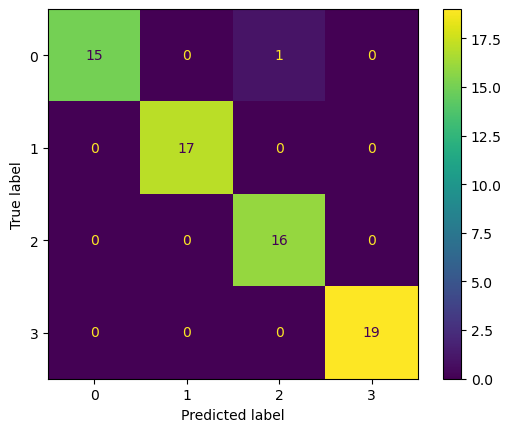

In [97]:
configs = Details(
    task = 'classification',
    pred_len = 4,      
    seq_len  = 728,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the classify each spectra given the different wavelengths " ,
    dropout = 0.05, 
    n_heads = 8, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, validation = model_selection.train_test_split(cancer, test_size=0.1, random_state=1, stratify= cancer['outcome'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("class_model_cancer_small_drop.pth", map_location=device))

eval_model(train, test,model, task = 'classification')

### CNN

Epoch  1 — train Accuracy 0.632231 - train F1 0.631818 — val Accuracy 0.851852 - val F1 0.843621
Epoch  2 — train Accuracy 0.863636 - train F1 0.863555 — val Accuracy 0.888889 - val F1 0.882123
Epoch  3 — train Accuracy 0.983471 - train F1 0.983504 — val Accuracy 1.000000 - val F1 1.000000
Epoch  4 — train Accuracy 0.995868 - train F1 0.995870 — val Accuracy 1.000000 - val F1 1.000000
Epoch  5 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch  6 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch  7 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch  8 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch  9 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch 10 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 1.000000 - val F1 1.000000
Epoch 11 — train Accuracy 1.00

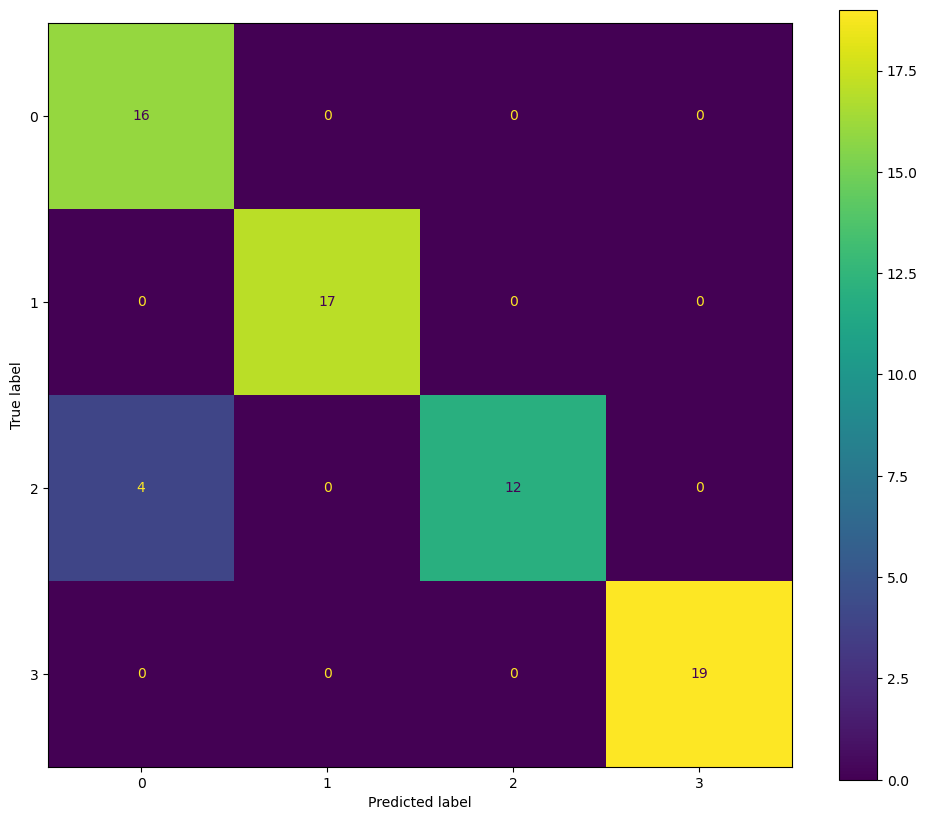

Test Accuracy 0.941176 — Test F1 0.940243


In [84]:
train, validation = model_selection.train_test_split(cancer, test_size=0.1, random_state=1, stratify= cancer['outcome'])

model ,train_acc, train_f1, val_acc, val_f1 = train_eval_cnn(train, validation, test, epochs = 100, input_length = cancer.shape[1] - 1, n_classes = 4, batch_size = 16, updates = True, file_name = 'cnn_cancer_mod.pth',earlystop = True, patience = 10)

### Random forest

In [39]:
X_train = cancer.iloc[:,1:]
y_train = cancer.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]


In [14]:
rfc = RandomForestClassifier()

cv_scores = model_selection.cross_val_score(rfc, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[1.         0.96296296 1.         1.         0.94339623]
0.9812718378756115


In [42]:
rfc = Pipeline([
    ("RandomForest", RandomForestClassifier())])
rfc.fit(X_train, y_train)

train_acc = rfc.score(X_train, y_train)
test_acc = rfc.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 1.000000 - Test accuracy 1.000000


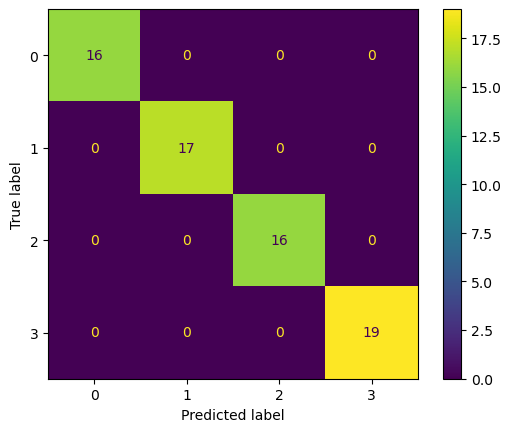

In [31]:
cm = confusion_matrix(y_test, rfc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### SVM Classifier

In [43]:
X_train = cancer.iloc[:,1:]
y_train = cancer.iloc[:,0]

X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

scaler = StandardScaler()

normalized = scaler.fit_transform(X_train.T).T
X_train = pd.DataFrame(normalized, columns = X_train.columns)

normalized = scaler.fit_transform(X_test.T).T
X_test = pd.DataFrame(normalized, columns = X_test.columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)


In [164]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

cv_scores = model_selection.cross_val_score(svm, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[1.         0.98148148 0.96296296 0.98148148 0.94339623]
0.973864430468204


In [43]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

svm.fit(X_train, y_train)

train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 0.996283 - Test accuracy 0.911765


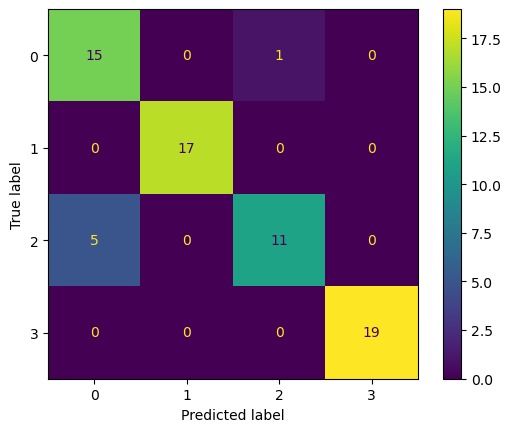

In [166]:
cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [44]:
svm = Pipeline([
    ("PCA", PCA(0.9)),
    ("RandomForest", SVC(kernel='rbf', C=1.0, gamma='scale'))])

svm.fit(X_train, y_train)

train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 0.959108 - Test accuracy 0.911765


## Bacteria2

In [45]:
bacteria2 = pd.read_csv('finetune.csv')
bacteria2 = bacteria2[['label'] + list(bacteria2.columns[:-1])]

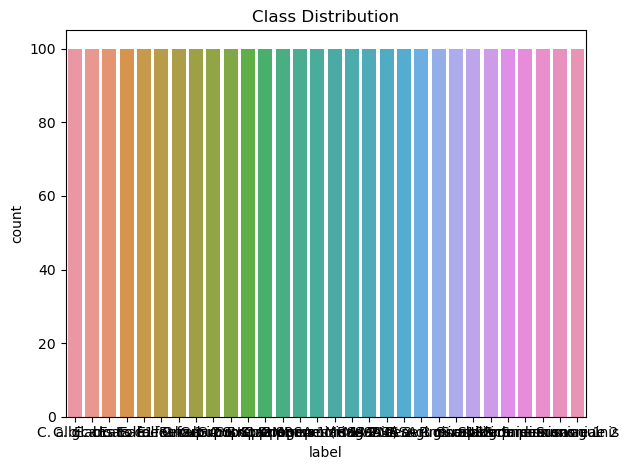

In [10]:
plt.figure()
sns.countplot(bacteria2, x='label', order=sorted(bacteria2['label'].value_counts().index))
plt.title(f'Class Distribution')
plt.tight_layout()
plt.show()

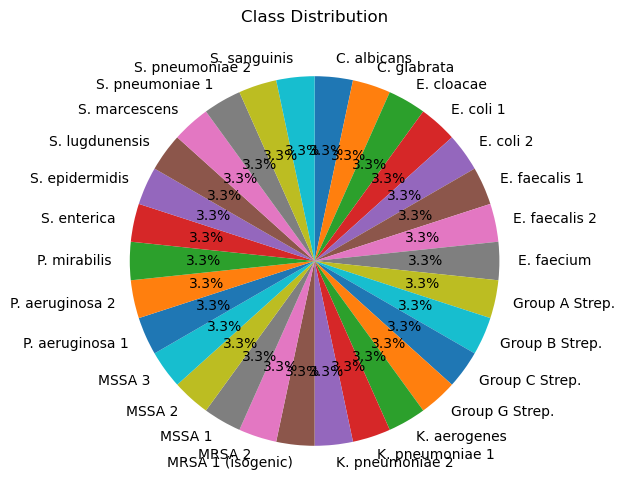

In [11]:
counts = bacteria2['label'].value_counts().sort_index()  
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',   
    startangle=90,       
    counterclock=False   
)
plt.title('Class Distribution')
plt.show()

In [10]:
le = LabelEncoder()
bacteria2['label'] = le.fit_transform(bacteria2['label'])
n_classes = bacteria2['label'].unique().shape[0]
input_len = bacteria2.shape[1] -1
bacteria2

,label,381.98,383.54,385.09,386.65,388.21,389.76,391.32,392.87,394.43,...,1780.9,1782.2,1783.5,1784.8,1786.0,1787.3,1788.6,1789.9,1791.2,1792.4
0,0,0.271837,0.288612,0.280069,0.238326,0.149782,0.287520,0.314087,0.436254,0.220946,...,0.351188,0.300570,0.337748,0.322260,0.318476,0.308860,0.295400,0.264347,0.250829,0.251005
1,0,0.338544,0.333446,0.216974,0.297642,0.292803,0.317914,0.390955,0.300769,0.417759,...,0.371779,0.344837,0.431439,0.344777,0.357700,0.275061,0.363754,0.273149,0.335895,0.342885
2,0,0.226345,0.284211,0.313471,0.176886,0.140678,0.104509,0.291582,0.333313,0.325921,...,0.304646,0.229723,0.224420,0.284641,0.244507,0.237156,0.207322,0.249094,0.280627,0.318304
3,0,0.158942,0.229800,0.195643,0.256019,0.272322,0.154162,0.279739,0.245662,0.280936,...,0.361150,0.328690,0.264717,0.261692,0.256544,0.322829,0.258918,0.209654,0.240220,0.232972
4,0,0.271528,0.227935,0.302354,0.094463,0.236362,0.287710,0.214766,0.175572,0.201721,...,0.285160,0.272645,0.310697,0.285540,0.239312,0.216241,0.241693,0.267104,0.279851,0.246244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,11,0.480288,0.383590,0.201467,0.307559,0.306897,0.423633,0.454955,0.582345,0.528231,...,0.449148,0.510296,0.272522,0.440394,0.341379,0.317071,0.186062,0.364555,0.276163,0.337205
2996,11,0.588278,0.480984,0.556382,0.277154,0.288105,0.793397,0.363739,0.428433,0.192235,...,0.487152,0.357732,0.282022,0.356743,0.356206,0.344911,0.484122,0.322322,0.386178,0.396280
2997,11,0.159706,0.279575,0.529267,0.540919,0.498453,0.347792,0.435137,0.609017,0.382566,...,0.471880,0.348560,0.387510,0.426449,0.443728,0.331162,0.424199,0.311611,0.231450,0.324400
2998,11,0.484724,0.385259,0.470935,0.436778,0.467950,0.553550,0.584669,0.583078,0.657699,...,0.228448,0.279825,0.352964,0.349838,0.335809,0.354435,0.275076,0.304560,0.388483,0.309004


### Random Forest

In [46]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

test.columns = test.columns.astype(str)
train.columns = train.columns.astype(str)

y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

scaler = StandardScaler()

normalized = scaler.fit_transform(train.iloc[:,1:].T).T
X_train = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)


In [66]:
rfc = RandomForestClassifier()

cv_scores = model_selection.cross_val_score(rfc, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[0.6328125  0.64583333 0.62760417 0.61979167 0.66145833]
0.6375


In [71]:
rfc = RandomForestClassifier()

cv_scores = model_selection.cross_val_score(rfc, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[0.6038961  0.56677524 0.58631922 0.60260586 0.54071661]
0.5800626084013707


In [72]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

train_acc = rfc.score(X_train, y_train)
test_acc = rfc.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 1.000000 - Test accuracy 0.593750


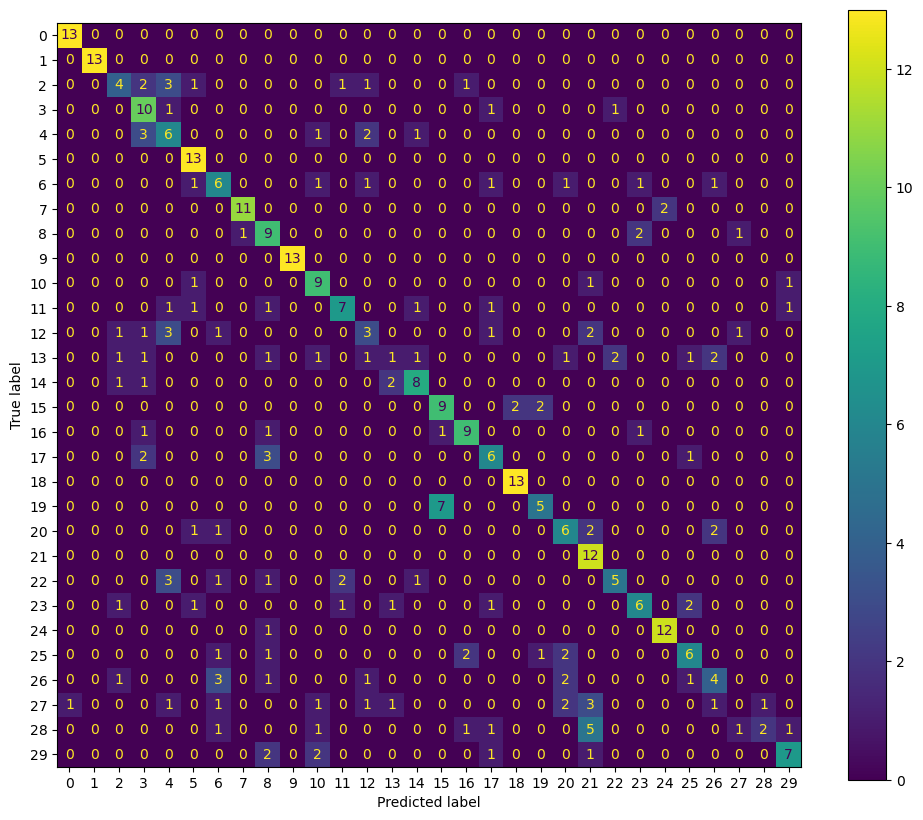

In [73]:
cm = confusion_matrix(y_test, rfc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax = ax)
plt.show()

#### Grid search

Train accuracy : 1.000000 - Test accuracy 0.815000
Best params {'PCA__n_components': 0.9}


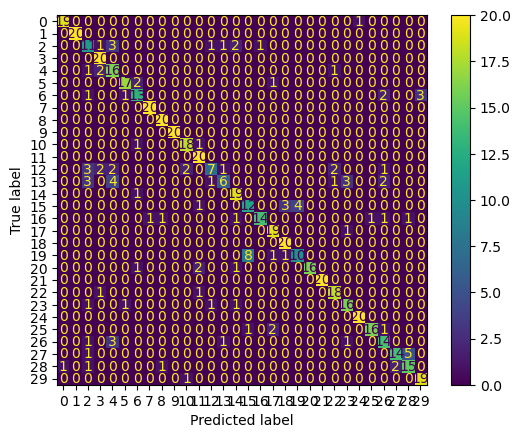

In [48]:
rfc = Pipeline([
    ('PCA', PCA()),
    ('RandomForest', RandomForestClassifier())])

param_rfc = {
    'PCA__n_components': [0.9, 0.95, 0.99]
}

search_rf = GridSearchCV(rfc, param_rfc, scoring="accuracy", cv = 5)

search_rf.fit(X_train, y_train)

train_acc = search_rf.best_estimator_.score(X_train, y_train)
test_acc = search_rf.best_estimator_.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')
print(f'Best params {search_rf.best_params_}')
cm = confusion_matrix(y_test, search_rf.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### SVM Classifier


In [120]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

cv_scores = model_selection.cross_val_score(svm, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[0.81041667 0.88333333 0.85416667 0.825      0.85416667]
0.8454166666666667


In [129]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

svm.fit(X_train, y_train)

train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 0.990417 - Test accuracy 0.881667


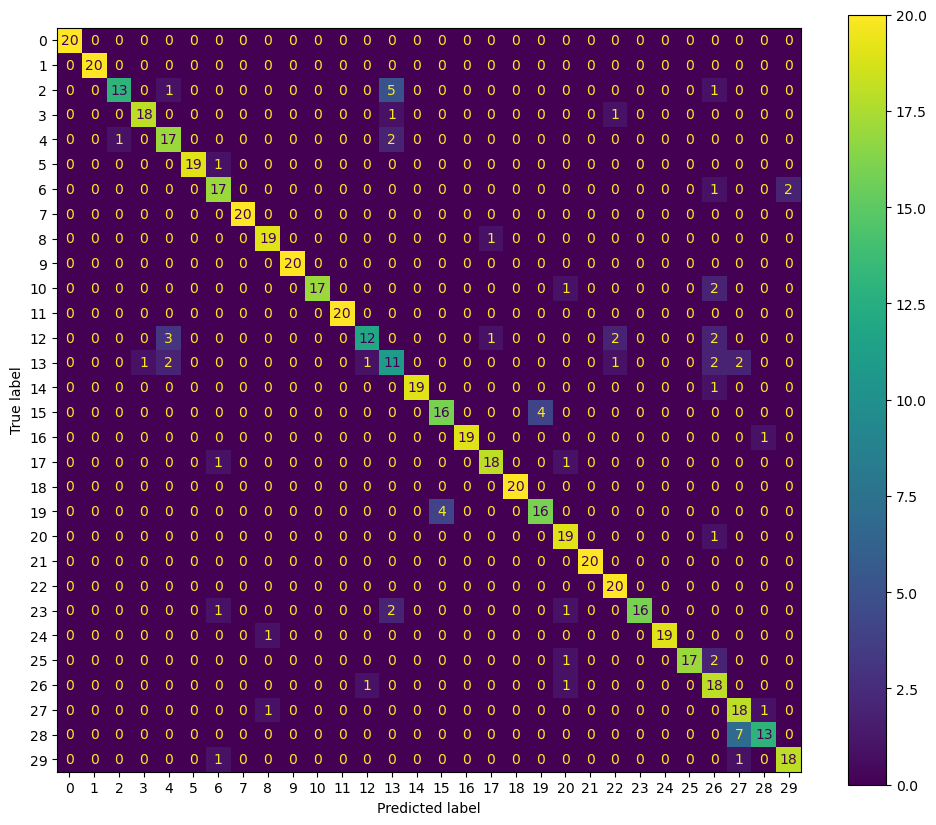

In [131]:
cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax = ax)
plt.show()

In [49]:
svm = Pipeline([
    ('PCA', PCA()),
    ('SVM', SVC(kernel='rbf', C=1.0, gamma='scale'))])

param_svm = {
    'PCA__n_components': [0.9, 0.95, 0.99]
}

search_svm = GridSearchCV(svm, param_svm, scoring="accuracy", cv = 5)

search_svm.fit(X_train, y_train)

train_acc = search_svm.best_estimator_.score(X_train, y_train)
test_acc = search_svm.best_estimator_.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 1.000000 - Test accuracy 0.896667


In [50]:
search_svm.best_params_

{'PCA__n_components': 0.99}

### CNN 

Epoch  1 — train Accuracy 0.575000 - train F1 0.574190 — val Accuracy 0.845833 - val F1 0.843169
Epoch  2 — train Accuracy 0.905208 - train F1 0.905067 — val Accuracy 0.850000 - val F1 0.852080
Epoch  3 — train Accuracy 0.964583 - train F1 0.964432 — val Accuracy 0.887500 - val F1 0.884795
Epoch  4 — train Accuracy 0.989583 - train F1 0.989571 — val Accuracy 0.916667 - val F1 0.915437
Epoch  5 — train Accuracy 0.998958 - train F1 0.998958 — val Accuracy 0.920833 - val F1 0.919630
Epoch  6 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.927083 - val F1 0.926026
Epoch  7 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.927083 - val F1 0.926200
Epoch  8 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.922917 - val F1 0.921688
Epoch  9 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.920833 - val F1 0.919524
Epoch 10 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.927083 - val F1 0.925834
Epoch 11 — train Accuracy 1.00

Epoch 17 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.927083 - val F1 0.926176
Epoch 18 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.922917 - val F1 0.922090
Epoch 19 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.927083 - val F1 0.926229
Epoch 20 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.922917 - val F1 0.922096
Epoch 21 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.929167 - val F1 0.928584
Early stopping triggered
Best results — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.935417 - val F1 0.934738


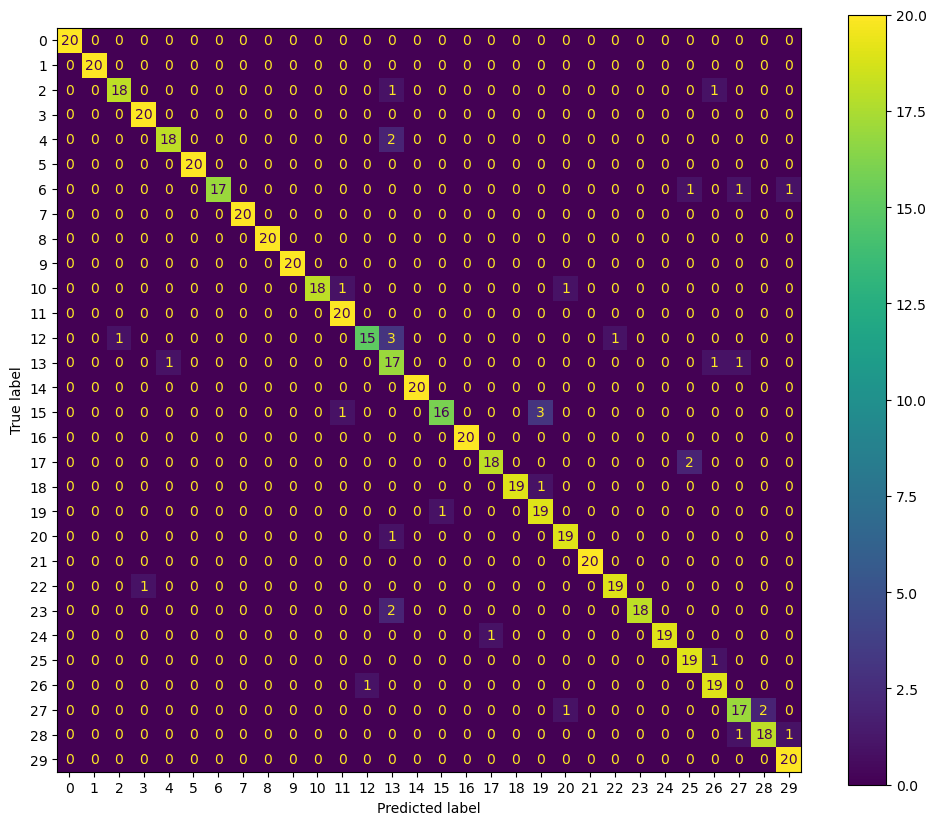

Test Accuracy 0.938333 — Test F1 0.938979


In [90]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])
train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])

model ,train_acc, train_f1, val_acc, val_f1 = train_eval_cnn(train, validation, test, epochs = 100, input_length = input_len, n_classes = n_classes, batch_size = 16, updates = True, file_name = 'cnn_bacteria2_mod.pth',earlystop = True, patience = 10)

### Raman-LLM

In [9]:
configs = Details(
    task = 'classification',
    pred_len = n_classes,      
    seq_len  = input_len,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
    dropout = 0.2, 
    n_heads = 4, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])
train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])


model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 100, 8, True, True, file_name = "best_class_model_bacteria2.pth")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train Accuracy : 0.177604 - train F1 0.180452 — val Accuracy 0.764583 - val F1 0.753127
Epoch  2 — train Accuracy : 0.695833 - train F1 0.698034 — val Accuracy 0.872917 - val F1 0.874171
Epoch  3 — train Accuracy : 0.739062 - train F1 0.741980 — val Accuracy 0.895833 - val F1 0.893991
Epoch  4 — train Accuracy : 0.791146 - train F1 0.795149 — val Accuracy 0.868750 - val F1 0.860803
Epoch  5 — train Accuracy : 0.789062 - train F1 0.793711 — val Accuracy 0.906250 - val F1 0.902702
Epoch  6 — train Accuracy : 0.811458 - train F1 0.816741 — val Accuracy 0.904167 - val F1 0.901230
Epoch  7 — train Accuracy : 0.820833 - train F1 0.826113 — val Accuracy 0.925000 - val F1 0.923934
Epoch  8 — train Accuracy : 0.821875 - train F1 0.827216 — val Accuracy 0.906250 - val F1 0.904192
Epoch  9 — train Accuracy : 0.826562 - train F1 0.832829 — val Accuracy 0.922917 - val F1 0.921554
Epoch 10 — train Accuracy : 0.821354 - train F1 0.829031 — val Accuracy 0.906250 - val F1 0.905416
Epoch 11 —

Load model and test in new data

In [124]:
configs = Details(
    task = 'classification',
    pred_len = 4,      
    seq_len  = 728,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements in a " \
                  "phosphate-buffered saline (PBS) solution. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to predict the classify each spectra given the different wavelengths " ,
    dropout = 0.05, 
    n_heads = 8, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("best_class_model_bacteria2.pth", map_location=device))

eval_model(train, test,model, task = 'classification')

Test Accuracy 0.920000 — Test F1 0.920545


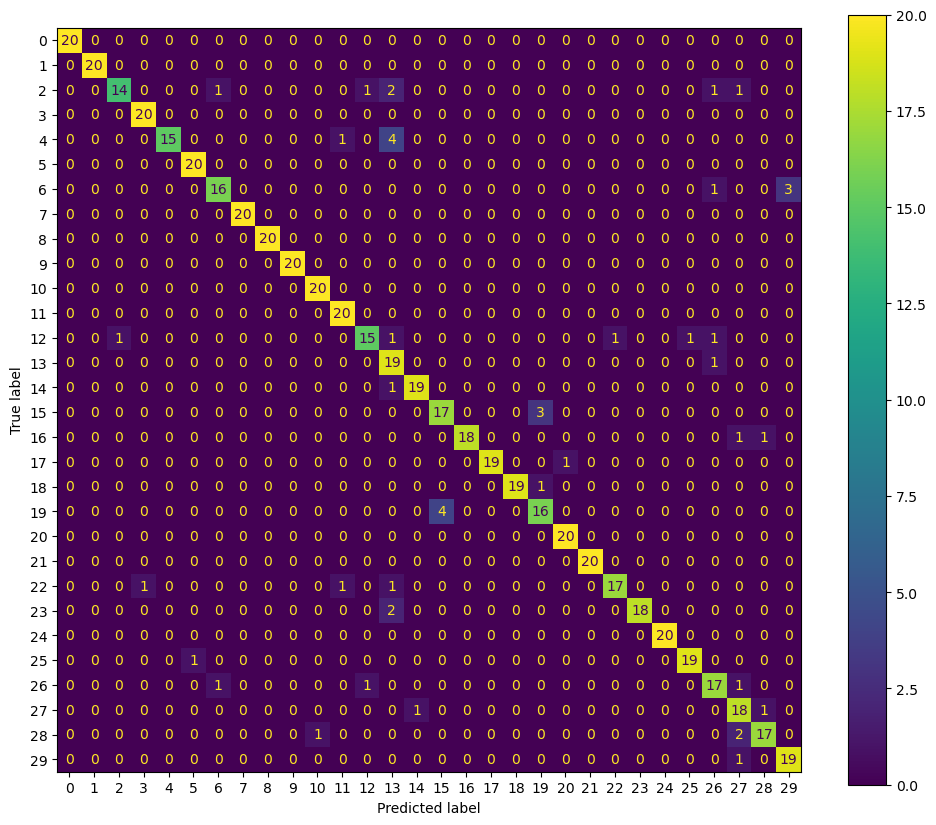

In [125]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(ax = ax)
plt.show()

##### 1.Hyperparameter search

In [19]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'd_model', 'd_ff', 'lr', 'train_acc', 'train_f1', 'val_acc', 'val_f1']

only_lact_search = pd.DataFrame(columns=columns)

random_trials = 100

for t in range(random_trials):

    set_seed(1000 + t)

    patch_len= random.choice([16, 24, 32, 48, 64, 96])
    stride = random.choice([8, 16, 24, 32, 48])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0, 0.005, 0.01, 0.1])
    n_heads = random.choice([2, 4, 6, 8])
    d_model = random.choice([16, 32, 64])
    d_ff = random.choice([2*d_model, 4*d_model])
    lr = random.choice([0.01, 0.001, 0.0001])

    if stride > patch_len:
        stride = patch_len 

    configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = d_model,
            d_ff = d_ff,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )
    
    model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 25, 8, updates = False, earlystop= True, patience = 5, file_name = 'classific_hyperseacrh.pth', scale_wavelengths=True, save = False)
    
    only_lact_search.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, d_model, d_ff, lr, float(train_acc), float(train_f1), float(val_acc), float(val_f1)]


# 332 min 


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.911979 - train F1 0.911884 — val Accuracy 0.866667 - val F1 0.867045


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.901563 - train F1 0.902436 — val Accuracy 0.906250 - val F1 0.905605


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.779687 - train F1 0.778430 — val Accuracy 0.758333 - val F1 0.756637


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.840625 - train F1 0.840135 — val Accuracy 0.781250 - val F1 0.770670


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 10 epochs
Best results — train Accuracy 0.961979 - train F1 0.961949 — val Accuracy 0.906250 - val F1 0.907159


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 23 epochs
Best results — train Accuracy 0.808333 - train F1 0.809313 — val Accuracy 0.797917 - val F1 0.792477


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 16 epochs
Best results — train Accuracy 0.890104 - train F1 0.891093 — val Accuracy 0.872917 - val F1 0.871078


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 25 epochs
Best results — train Accuracy 0.990625 - train F1 0.990628 — val Accuracy 0.897917 - val F1 0.897881


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
only_lact_search

,patch_len,stride,llm_layers,dropout,n_heads,d_model,d_ff,lr,train_acc,train_f1,val_acc,val_f1
0,48.0,8.0,6.0,0.010,2.0,32.0,64.0,0.0001,0.911979,0.911884,0.866667,0.867045
1,16.0,16.0,4.0,0.100,4.0,32.0,128.0,0.0001,0.901563,0.902436,0.906250,0.905605
2,64.0,48.0,6.0,0.005,4.0,16.0,64.0,0.0010,0.779687,0.778430,0.758333,0.756637
3,48.0,48.0,6.0,0.005,8.0,32.0,128.0,0.0010,0.840625,0.840135,0.781250,0.770670
4,48.0,8.0,8.0,0.005,4.0,32.0,64.0,0.0001,0.961979,0.961949,0.906250,0.907159
5,48.0,32.0,8.0,0.100,6.0,32.0,64.0,0.0010,0.808333,0.809313,0.797917,0.792477
6,32.0,8.0,4.0,0.100,2.0,16.0,64.0,0.0001,0.890104,0.891093,0.872917,0.871078
7,16.0,16.0,4.0,0.010,4.0,16.0,32.0,0.0001,0.990625,0.990628,0.897917,0.897881


In [21]:
#only_lact_search.to_excel("bacteria_search.xlsx", index=False)

In [ ]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'd_model', 'd_ff', 'lr', 'train_acc', 'train_f1', 'val_acc', 'val_f1']

bacteria_search = pd.DataFrame(columns=columns)

random_trials = 100

for t in range(random_trials):

    set_seed(1000 + t)

    patch_len= random.choice([16, 24, 32, 48, 64, 96])
    stride = random.choice([8, 16, 24, 32, 48])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0.01, 0.1, 0.2, 0.3])
    n_heads = random.choice([2, 4, 6, 8])
    d_model = random.choice([16, 32, 64])
    d_ff = random.choice([2*d_model, 4*d_model])
    lr = random.choice([0.01, 0.001, 0.0001])

    if stride > patch_len:
        stride = patch_len 

    configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = d_model,
            d_ff = d_ff,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )
    
    model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 25, 8, updates = False, earlystop= True, patience = 5, file_name = 'classific_hyperseacrh.pth', scale_wavelengths=True, save = False)
    
    bacteria_search.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, d_model, d_ff, lr, float(train_acc), float(train_f1), float(val_acc), float(val_f1)]


# 4020 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.802604 - train F1 0.807002 — val Accuracy 0.870833 - val F1 0.869558


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.646354 - train F1 0.655510 — val Accuracy 0.862500 - val F1 0.861696


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.655729 - train F1 0.656208 — val Accuracy 0.722917 - val F1 0.716127


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.745833 - train F1 0.746136 — val Accuracy 0.797917 - val F1 0.783911


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 19 epochs
Best results — train Accuracy 0.918750 - train F1 0.919339 — val Accuracy 0.910417 - val F1 0.909200


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.608333 - train F1 0.613770 — val Accuracy 0.825000 - val F1 0.817529


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 19 epochs
Best results — train Accuracy 0.703646 - train F1 0.719295 — val Accuracy 0.895833 - val F1 0.893720


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 22 epochs
Best results — train Accuracy 0.809896 - train F1 0.817801 — val Accuracy 0.914583 - val F1 0.913116


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.976042 - train F1 0.975975 — val Accuracy 0.895833 - val F1 0.896027


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.929688 - train F1 0.929911 — val Accuracy 0.804167 - val F1 0.804656


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 19 epochs
Best results — train Accuracy 0.733333 - train F1 0.732762 — val Accuracy 0.677083 - val F1 0.668705


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 18 epochs
Best results — train Accuracy 0.614583 - train F1 0.620981 — val Accuracy 0.818750 - val F1 0.819983


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 19 epochs
Best results — train Accuracy 0.631771 - train F1 0.639999 — val Accuracy 0.850000 - val F1 0.846995


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.631250 - train F1 0.630731 — val Accuracy 0.720833 - val F1 0.711481


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 23 epochs
Best results — train Accuracy 0.825000 - train F1 0.834142 — val Accuracy 0.912500 - val F1 0.910901


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.639062 - train F1 0.647920 — val Accuracy 0.868750 - val F1 0.867153


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.645833 - train F1 0.648857 — val Accuracy 0.762500 - val F1 0.762650


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.855729 - train F1 0.854960 — val Accuracy 0.825000 - val F1 0.824558


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.744271 - train F1 0.742944 — val Accuracy 0.695833 - val F1 0.688661


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.894271 - train F1 0.893677 — val Accuracy 0.847917 - val F1 0.846875


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.677083 - train F1 0.686214 — val Accuracy 0.904167 - val F1 0.902138


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.894271 - train F1 0.894735 — val Accuracy 0.845833 - val F1 0.841625


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 18 epochs
Best results — train Accuracy 0.806250 - train F1 0.811473 — val Accuracy 0.897917 - val F1 0.897895


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.821354 - train F1 0.821739 — val Accuracy 0.893750 - val F1 0.893038


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.820833 - train F1 0.827262 — val Accuracy 0.902083 - val F1 0.900844


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.838021 - train F1 0.838906 — val Accuracy 0.866667 - val F1 0.862523


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.647396 - train F1 0.655898 — val Accuracy 0.862500 - val F1 0.858704


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.714063 - train F1 0.730226 — val Accuracy 0.895833 - val F1 0.893646


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.796354 - train F1 0.800318 — val Accuracy 0.904167 - val F1 0.904745


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.838021 - train F1 0.838124 — val Accuracy 0.825000 - val F1 0.822112


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.671875 - train F1 0.673269 — val Accuracy 0.750000 - val F1 0.743339


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.535937 - train F1 0.531287 — val Accuracy 0.552083 - val F1 0.537683


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.818750 - train F1 0.820056 — val Accuracy 0.800000 - val F1 0.796051


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 16 epochs
Best results — train Accuracy 0.798958 - train F1 0.804932 — val Accuracy 0.908333 - val F1 0.907798


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.906771 - train F1 0.906640 — val Accuracy 0.885417 - val F1 0.882760


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.654687 - train F1 0.654810 — val Accuracy 0.802083 - val F1 0.801405


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.889583 - train F1 0.889105 — val Accuracy 0.845833 - val F1 0.843424


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.567187 - train F1 0.571789 — val Accuracy 0.768750 - val F1 0.755601


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 17 epochs
Best results — train Accuracy 0.790104 - train F1 0.791157 — val Accuracy 0.804167 - val F1 0.795434


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 21 epochs
Best results — train Accuracy 0.663542 - train F1 0.662058 — val Accuracy 0.652083 - val F1 0.647529


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.825000 - train F1 0.826609 — val Accuracy 0.843750 - val F1 0.841944


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 17 epochs
Best results — train Accuracy 0.541146 - train F1 0.546332 — val Accuracy 0.760417 - val F1 0.754319


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.839063 - train F1 0.838998 — val Accuracy 0.837500 - val F1 0.833778


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 21 epochs
Best results — train Accuracy 0.546354 - train F1 0.551033 — val Accuracy 0.691667 - val F1 0.680929


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.497917 - train F1 0.501051 — val Accuracy 0.652083 - val F1 0.642099


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.704688 - train F1 0.717858 — val Accuracy 0.875000 - val F1 0.871269


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.626042 - train F1 0.623470 — val Accuracy 0.650000 - val F1 0.638928


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.689583 - train F1 0.692610 — val Accuracy 0.762500 - val F1 0.760048


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.661979 - train F1 0.661497 — val Accuracy 0.722917 - val F1 0.717195


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 16 epochs
Best results — train Accuracy 0.949479 - train F1 0.949433 — val Accuracy 0.837500 - val F1 0.837603


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 24 epochs
Best results — train Accuracy 0.560417 - train F1 0.565461 — val Accuracy 0.764583 - val F1 0.756302


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.556771 - train F1 0.562489 — val Accuracy 0.762500 - val F1 0.748176


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.816667 - train F1 0.816940 — val Accuracy 0.820833 - val F1 0.818326


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.780729 - train F1 0.786483 — val Accuracy 0.902083 - val F1 0.901638


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 17 epochs
Best results — train Accuracy 0.879167 - train F1 0.879891 — val Accuracy 0.868750 - val F1 0.868828


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 16 epochs
Best results — train Accuracy 0.889583 - train F1 0.890114 — val Accuracy 0.883333 - val F1 0.880787


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.902604 - train F1 0.903286 — val Accuracy 0.904167 - val F1 0.902782


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.672396 - train F1 0.682405 — val Accuracy 0.877083 - val F1 0.872986


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.463021 - train F1 0.463550 — val Accuracy 0.564583 - val F1 0.545731


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 8 epochs
Best results — train Accuracy 0.758333 - train F1 0.757720 — val Accuracy 0.847917 - val F1 0.847658


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.993229 - train F1 0.993228 — val Accuracy 0.902083 - val F1 0.898951


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.782292 - train F1 0.782675 — val Accuracy 0.768750 - val F1 0.764949


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 8 epochs
Best results — train Accuracy 0.504687 - train F1 0.503206 — val Accuracy 0.614583 - val F1 0.606612


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.582812 - train F1 0.586186 — val Accuracy 0.802083 - val F1 0.799014


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.654167 - train F1 0.655522 — val Accuracy 0.750000 - val F1 0.743244


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.919271 - train F1 0.919722 — val Accuracy 0.847917 - val F1 0.847185


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 23 epochs
Best results — train Accuracy 0.663542 - train F1 0.674948 — val Accuracy 0.864583 - val F1 0.862773


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.794271 - train F1 0.794841 — val Accuracy 0.814583 - val F1 0.811507


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 10 epochs
Best results — train Accuracy 0.506250 - train F1 0.508276 — val Accuracy 0.714583 - val F1 0.697760


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 17 epochs
Best results — train Accuracy 0.587500 - train F1 0.590546 — val Accuracy 0.808333 - val F1 0.803524


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.939583 - train F1 0.939675 — val Accuracy 0.870833 - val F1 0.865309


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 9 epochs
Best results — train Accuracy 0.736458 - train F1 0.736047 — val Accuracy 0.733333 - val F1 0.722497


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.606250 - train F1 0.610234 — val Accuracy 0.825000 - val F1 0.819304


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.865625 - train F1 0.865374 — val Accuracy 0.743750 - val F1 0.743937


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.490625 - train F1 0.488472 — val Accuracy 0.529167 - val F1 0.509980


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 10 epochs
Best results — train Accuracy 0.893229 - train F1 0.893532 — val Accuracy 0.847917 - val F1 0.846431


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 23 epochs
Best results — train Accuracy 0.722396 - train F1 0.742746 — val Accuracy 0.900000 - val F1 0.897584


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.768750 - train F1 0.772907 — val Accuracy 0.852083 - val F1 0.847460


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.631771 - train F1 0.638308 — val Accuracy 0.825000 - val F1 0.822963


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 8 epochs
Best results — train Accuracy 0.654687 - train F1 0.652730 — val Accuracy 0.750000 - val F1 0.741197


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.770833 - train F1 0.769608 — val Accuracy 0.760417 - val F1 0.763139


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 22 epochs
Best results — train Accuracy 0.881250 - train F1 0.881033 — val Accuracy 0.831250 - val F1 0.829839


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.733854 - train F1 0.733975 — val Accuracy 0.677083 - val F1 0.665773


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.586458 - train F1 0.587792 — val Accuracy 0.681250 - val F1 0.663585


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 13 epochs
Best results — train Accuracy 0.690625 - train F1 0.709411 — val Accuracy 0.904167 - val F1 0.902791


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 20 epochs
Best results — train Accuracy 0.511979 - train F1 0.512033 — val Accuracy 0.612500 - val F1 0.599090


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 10 epochs
Best results — train Accuracy 0.547396 - train F1 0.551119 — val Accuracy 0.758333 - val F1 0.752090


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
#bacteria_search.to_excel("bacteria_search2.xlsx", index=False)

In [47]:
bacteria_search1 = pd.read_excel("bacteria_search.xlsx")
bacteria_search2 = pd.read_excel("bacteria_search2.xlsx")

bacteria_search = pd.concat([bacteria_search1, bacteria_search2], axis=0, ignore_index=True)
bacteria_search.sort_values('val_acc', ascending=False).head(30)

,patch_len,stride,llm_layers,dropout,n_heads,d_model,d_ff,lr,train_acc,train_f1,val_acc,val_f1
15,16,16,4,0.200,4,16,32,0.0001,0.809896,0.817801,0.914583,0.913116
22,64,8,4,0.200,2,32,128,0.0001,0.825000,0.834142,0.912500,0.910901
12,48,8,8,0.100,4,32,64,0.0001,0.918750,0.919339,0.910417,0.909200
41,96,16,8,0.200,8,16,32,0.0001,0.798958,0.804932,0.908333,0.907798
4,48,8,8,0.005,4,32,64,0.0001,0.961979,0.961949,0.906250,0.907159
1,16,16,4,0.100,4,32,128,0.0001,0.901563,0.902436,0.906250,0.905605
92,96,8,8,0.300,8,32,64,0.0001,0.690625,0.709411,0.904167,0.902791
28,16,8,6,0.300,4,32,64,0.0001,0.677083,0.686214,0.904167,0.902138
36,48,48,6,0.200,4,32,128,0.0001,0.796354,0.800318,0.904167,0.904745
64,16,16,6,0.100,6,32,64,0.0001,0.902604,0.903286,0.904167,0.902782


In [49]:
bacteria_search['lr'].value_counts()

0.0010    39
0.0001    31
0.0100    25
Name: lr, dtype: int64

In [52]:
import plotly.express as px

df = bacteria_search  

metric_col = "val_acc"
lower_is_better = False

exclude = {"train_f1", "val_f1"}
hyperparam_cols = [c for c in df.columns
                   if c not in exclude and c != metric_col and not c.startswith("split")]

df = df.copy()
df["score_color"] = (-df[metric_col] if lower_is_better else df[metric_col])

df_enc = df.copy()
for c in hyperparam_cols:
    if not np.issubdtype(df_enc[c].dtype, np.number):
        mapping = {k: i for i, k in enumerate(sorted(df_enc[c].astype(str).unique()))}
        df_enc[c] = df_enc[c].astype(str).map(mapping)

strong_red_scale = [
    [0.00, "rgb(255,180,180)"],
    [0.20, "rgb(255,140,140)"],
    [0.40, "rgb(255,100,100)"],
    [0.60, "rgb(235,60,60)"],
    [0.80, "rgb(205,35,35)"],
    [1.00, "rgb(139,0,0)"],
]

lo, hi = np.percentile(df["score_color"], [5, 95])

fig = px.parallel_coordinates(
    df_enc,
    dimensions=hyperparam_cols + [metric_col],
    color="score_color",
    color_continuous_scale=strong_red_scale,
    range_color=(lo, hi),
    labels={**{c: c for c in hyperparam_cols}, metric_col: metric_col},
)

fig.update_layout(
    paper_bgcolor="white",
    plot_bgcolor="white",
)

fig.show()

/opt/anaconda3/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



##### 2.Hyperparameter search

In [12]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'lr', 'train_acc', 'train_f1', 'val_acc', 'val_f1']

bacteria_search3 = pd.DataFrame(columns=columns)

random_trials = 50

for t in range(random_trials):

    set_seed(1000 + t)

    patch_len= random.choice([16, 32, 64, 128])
    stride = random.choice([8, 16, 32, 64])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0, 0.1, 0.2, 0.3])
    n_heads = random.choice([2, 4, 6, 8])
    lr = random.choice([0.0001, 0.00001])

    if stride > patch_len:
        stride = patch_len 

    configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = 16,
            d_ff = 32,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )
    
    model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 50, 8, updates = False, earlystop= True, patience = 7, file_name = 'classific_hyperseacrh3.pth', scale_wavelengths=True, save = False)
    
    bacteria_search3.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, lr, float(train_acc), float(train_f1), float(val_acc), float(val_f1)]


# 520 min

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.836458 - train F1 0.842749 — val Accuracy 0.902083 - val F1 0.902108


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 46 epochs
Best results — train Accuracy 0.698958 - train F1 0.705129 — val Accuracy 0.893750 - val F1 0.892571


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 41 epochs
Best results — train Accuracy 0.915625 - train F1 0.915694 — val Accuracy 0.870833 - val F1 0.868276


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.692708 - train F1 0.701428 — val Accuracy 0.895833 - val F1 0.893754


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 28 epochs
Best results — train Accuracy 0.889062 - train F1 0.889879 — val Accuracy 0.893750 - val F1 0.892950


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 76.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 24.50 MiB is free. Including non-PyTorch memory, this process has 23.59 GiB memory in use. Of the allocated memory 21.30 GiB is allocated by PyTorch, and 1.01 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
#bacteria_search3.to_excel("bacteria_search3.xlsx", index=False)

In [14]:
bacteria_search3

,patch_len,stride,llm_layers,dropout,n_heads,lr,train_acc,train_f1,val_acc,val_f1
0,128.0,8.0,6.0,0.2,2.0,0.00001,0.836458,0.842749,0.902083,0.902108
1,16.0,16.0,4.0,0.3,4.0,0.00001,0.698958,0.705129,0.893750,0.892571
2,128.0,16.0,4.0,0.1,6.0,0.00001,0.915625,0.915694,0.870833,0.868276
3,128.0,32.0,4.0,0.3,8.0,0.00001,0.692708,0.701428,0.895833,0.893754
4,128.0,8.0,8.0,0.1,4.0,0.00001,0.889062,0.889879,0.893750,0.892950


In [15]:
patch_len,stride, llm_layers,dropout, n_heads

(128, 64, 8, 0.3, 6)

In [ ]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'lr', 'train_acc', 'train_f1', 'val_acc', 'val_f1']

bacteria_search4 = pd.DataFrame(columns=columns)

random_trials = 50

for t in range(5,random_trials):

    set_seed(1000 + t)

    patch_len= random.choice([16, 32, 64, 128])
    stride = random.choice([8, 16, 32, 64])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0, 0.1, 0.2, 0.3])
    n_heads = random.choice([2, 4, 6, 8])
    lr = random.choice([0.0001, 0.00001])

    if stride > patch_len:
        stride = patch_len 
    configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = 16,
            d_ff = 32,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )
    
    print(patch_len,stride, llm_layers,dropout, n_heads, lr)
    model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 50, 8, updates = False, earlystop= True, patience = 7, file_name = 'classific_hyperseacrh4.pth', scale_wavelengths=True, save = False)
    
    bacteria_search4.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, lr, float(train_acc), float(train_f1), float(val_acc), float(val_f1)]

 # 8 horas   

128 64 8 0.3 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.650521 - train F1 0.654644 — val Accuracy 0.875000 - val F1 0.874018
64 8 4 0.3 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 23 epochs
Best results — train Accuracy 0.720313 - train F1 0.744961 — val Accuracy 0.910417 - val F1 0.908704
16 16 6 0.1 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 31 epochs
Best results — train Accuracy 0.917708 - train F1 0.918721 — val Accuracy 0.916667 - val F1 0.916197
128 32 4 0 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 29 epochs
Best results — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.870833 - val F1 0.869928
32 8 6 0 8 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 14 epochs
Best results — train Accuracy 0.998958 - train F1 0.998958 — val Accuracy 0.902083 - val F1 0.899825
32 8 6 0.3 8 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [18]:

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'lr']

bacteria_search4 = pd.DataFrame(columns=columns)
for t in range(5,10):

    set_seed(1000 + t)

    patch_len= random.choice([16, 32, 64, 128])
    stride = random.choice([8, 16, 32, 64])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0, 0.1, 0.2, 0.3])
    n_heads = random.choice([2, 4, 6, 8])
    lr = random.choice([0.0001, 0.00001])

    bacteria_search4.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, lr]

bacteria_search4

,patch_len,stride,llm_layers,dropout,n_heads,lr
5,128.0,64.0,8.0,0.3,6.0,0.00001
6,64.0,8.0,4.0,0.3,2.0,0.00010
7,16.0,16.0,6.0,0.1,4.0,0.00010
8,128.0,32.0,4.0,0.0,2.0,0.00010
9,32.0,8.0,6.0,0.0,8.0,0.00010


In [20]:
results = pd.read_csv('TrainValidationAcc.csv')

In [28]:
bacteria_search4_complete = pd.concat([bacteria_search4.reset_index(drop=True), results.reset_index(drop=True)], axis=1)
bacteria_search4_complete


,patch_len,stride,llm_layers,dropout,n_heads,lr,train_acc,train_f1,val_acc,val_f1
0,128.0,64.0,8.0,0.3,6.0,0.00001,0.650521,0.654644,0.875000,0.874018
1,64.0,8.0,4.0,0.3,2.0,0.00010,0.720313,0.744961,0.910417,0.908704
2,16.0,16.0,6.0,0.1,4.0,0.00010,0.917708,0.918721,0.916667,0.916197
3,128.0,32.0,4.0,0.0,2.0,0.00010,1.000000,1.000000,0.870833,0.869928
4,32.0,8.0,6.0,0.0,8.0,0.00010,0.998958,0.998958,0.902083,0.899825


In [50]:
bacteria_search4_complete

,patch_len,stride,llm_layers,dropout,n_heads,lr,train_acc,train_f1,val_acc,val_f1
0,128.0,64.0,8.0,0.3,6.0,0.00001,0.650521,0.654644,0.875000,0.874018
1,64.0,8.0,4.0,0.3,2.0,0.00010,0.720313,0.744961,0.910417,0.908704
2,16.0,16.0,6.0,0.1,4.0,0.00010,0.917708,0.918721,0.916667,0.916197
3,128.0,32.0,4.0,0.0,2.0,0.00010,1.000000,1.000000,0.870833,0.869928
4,32.0,8.0,6.0,0.0,8.0,0.00010,0.998958,0.998958,0.902083,0.899825


In [51]:
#bacteria_search4_complete.to_excel("bacteria_search4_1.xlsx", index=False)

In [45]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

columns = ['patch_len','stride', 'llm_layers','dropout', 'n_heads', 'lr', 'train_acc', 'train_f1', 'val_acc', 'val_f1']

bacteria_search4 = pd.DataFrame(columns=columns)

random_trials = 50

for t in range(10,random_trials):

    set_seed(1000 + t)

    patch_len= random.choice([16, 32, 64, 128])
    stride = random.choice([8, 16, 32, 64])
    llm_layers = random.choice([4, 6, 8])       
    dropout = random.choice([0, 0.1, 0.2, 0.3])
    n_heads = random.choice([2, 4, 6, 8])
    lr = random.choice([0.0001, 0.00001])

    if stride > patch_len:
        stride = patch_len 
    configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = 16,
            d_ff = 32,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )
    
    print(patch_len,stride, llm_layers,dropout, n_heads, lr)
    model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 50, 8, updates = False, earlystop= True, patience = 7, file_name = 'classific_hyperseacrh4.pth', scale_wavelengths=True, save = False)
    
    bacteria_search4.loc[t] = [patch_len,stride, llm_layers,dropout, n_heads, lr, float(train_acc), float(train_f1), float(val_acc), float(val_f1)]

 #3884  min   

32 8 6 0.3 8 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 15 epochs
Best results — train Accuracy 0.713021 - train F1 0.728526 — val Accuracy 0.908333 - val F1 0.906003
64 32 4 0.3 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 47 epochs
Best results — train Accuracy 0.658333 - train F1 0.663481 — val Accuracy 0.866667 - val F1 0.866082
64 16 4 0.3 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 19 epochs
Best results — train Accuracy 0.697396 - train F1 0.717642 — val Accuracy 0.914583 - val F1 0.913992
128 32 8 0.1 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.872917 - train F1 0.873734 — val Accuracy 0.877083 - val F1 0.875337
16 16 6 0 8 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 37 epochs
Best results — train Accuracy 0.999479 - train F1 0.999479 — val Accuracy 0.845833 - val F1 0.844613
16 16 6 0.3 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.713021 - train F1 0.725865 — val Accuracy 0.920833 - val F1 0.918479
64 64 8 0.2 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 32 epochs
Best results — train Accuracy 0.805208 - train F1 0.808622 — val Accuracy 0.868750 - val F1 0.867207
128 64 4 0 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 42 epochs
Best results — train Accuracy 0.977604 - train F1 0.977456 — val Accuracy 0.812500 - val F1 0.810293
128 64 8 0 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.979688 - train F1 0.979745 — val Accuracy 0.804167 - val F1 0.798556
16 16 4 0 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 36 epochs
Best results — train Accuracy 0.998437 - train F1 0.998437 — val Accuracy 0.872917 - val F1 0.873074
16 8 6 0.3 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.711979 - train F1 0.722683 — val Accuracy 0.910417 - val F1 0.909013
32 16 6 0.3 8 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 49 epochs
Best results — train Accuracy 0.703125 - train F1 0.719443 — val Accuracy 0.908333 - val F1 0.908172
32 32 8 0.2 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.770833 - train F1 0.773450 — val Accuracy 0.856250 - val F1 0.854979
128 64 6 0.1 8 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.907292 - train F1 0.907829 — val Accuracy 0.845833 - val F1 0.844269
16 16 6 0.2 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 35 epochs
Best results — train Accuracy 0.758333 - train F1 0.760585 — val Accuracy 0.887500 - val F1 0.884292
32 8 4 0.1 6 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 12 epochs
Best results — train Accuracy 0.888542 - train F1 0.889005 — val Accuracy 0.918750 - val F1 0.918332
16 16 6 0.3 6 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 27 epochs
Best results — train Accuracy 0.723958 - train F1 0.744834 — val Accuracy 0.902083 - val F1 0.899603
16 8 4 0.3 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 26 epochs
Best results — train Accuracy 0.722396 - train F1 0.746805 — val Accuracy 0.927083 - val F1 0.925321
128 64 8 0.2 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.741146 - train F1 0.743964 — val Accuracy 0.854167 - val F1 0.853343
64 16 8 0.3 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 41 epochs
Best results — train Accuracy 0.678646 - train F1 0.687227 — val Accuracy 0.908333 - val F1 0.906306
16 16 8 0.1 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.917188 - train F1 0.917616 — val Accuracy 0.904167 - val F1 0.903464
16 8 6 0.2 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 21 epochs
Best results — train Accuracy 0.761979 - train F1 0.766069 — val Accuracy 0.916667 - val F1 0.914478
128 64 4 0.2 4 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.716146 - train F1 0.717728 — val Accuracy 0.781250 - val F1 0.776379
32 32 6 0 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 25 epochs
Best results — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.889583 - val F1 0.888644
16 8 4 0 8 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 11 epochs
Best results — train Accuracy 0.953646 - train F1 0.953645 — val Accuracy 0.897917 - val F1 0.894725
128 16 6 0.1 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 16 epochs
Best results — train Accuracy 0.883333 - train F1 0.883876 — val Accuracy 0.891667 - val F1 0.890803
128 8 8 0 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 29 epochs
Best results — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.868750 - val F1 0.868935
16 16 8 0.3 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 28 epochs
Best results — train Accuracy 0.693229 - train F1 0.707673 — val Accuracy 0.912500 - val F1 0.912036
16 8 6 0.1 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 34 epochs
Best results — train Accuracy 0.910937 - train F1 0.911771 — val Accuracy 0.902083 - val F1 0.900354
32 16 8 0 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 18 epochs
Best results — train Accuracy 0.999479 - train F1 0.999479 — val Accuracy 0.883333 - val F1 0.880597
64 16 8 0.1 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Best results — train Accuracy 0.922917 - train F1 0.923423 — val Accuracy 0.910417 - val F1 0.909100
128 16 6 0.3 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 27 epochs
Best results — train Accuracy 0.717708 - train F1 0.739680 — val Accuracy 0.912500 - val F1 0.912754
32 16 6 0 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 49 epochs
Best results — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.906250 - val F1 0.903524
64 32 6 0.1 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 30 epochs
Best results — train Accuracy 0.919271 - train F1 0.919625 — val Accuracy 0.906250 - val F1 0.904746
32 32 6 0.3 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 24 epochs
Best results — train Accuracy 0.689063 - train F1 0.701677 — val Accuracy 0.897917 - val F1 0.897907
16 16 6 0.3 2 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 44 epochs
Best results — train Accuracy 0.683854 - train F1 0.693764 — val Accuracy 0.897917 - val F1 0.895726
128 64 4 0.2 6 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 40 epochs
Best results — train Accuracy 0.771354 - train F1 0.776233 — val Accuracy 0.864583 - val F1 0.863333
16 16 6 0.2 8 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 30 epochs
Best results — train Accuracy 0.791146 - train F1 0.793152 — val Accuracy 0.902083 - val F1 0.901448
64 32 4 0.1 2 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 44 epochs
Best results — train Accuracy 0.933333 - train F1 0.933715 — val Accuracy 0.900000 - val F1 0.899678
128 8 4 0.3 6 1e-05


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Early stopping triggered after 44 epochs
Best results — train Accuracy 0.728646 - train F1 0.744013 — val Accuracy 0.908333 - val F1 0.906481


In [53]:
#bacteria_search4.to_excel("bacteria_search4_2.xlsx", index=False)

In [60]:
bacteria_search3 = pd.read_excel('bacteria_search3.xlsx')

In [65]:
bacteria_search3

,patch_len,stride,llm_layers,dropout,n_heads,lr,train_acc,train_f1,val_acc,val_f1
0,128,8,6,0.2,2,0.00001,0.836458,0.842749,0.902083,0.902108
1,16,16,4,0.3,4,0.00001,0.698958,0.705129,0.893750,0.892571
2,128,16,4,0.1,6,0.00001,0.915625,0.915694,0.870833,0.868276
3,128,32,4,0.3,8,0.00001,0.692708,0.701428,0.895833,0.893754
4,128,8,8,0.1,4,0.00001,0.889062,0.889879,0.893750,0.892950


In [74]:
bacteria_search2_complete = pd.concat([bacteria_search3, bacteria_search4_complete, bacteria_search4], axis=0, ignore_index=True)

In [75]:
#bacteria_search2_complete.to_excel("bacteria_search2_complete.xlsx", index=False)

In [11]:
bacteria_search2_complete = pd.read_excel('bacteria_search2_complete.xlsx')
bacteria_search2_complete.sort_values('val_acc', ascending=False).head(30)

,patch_len,stride,llm_layers,dropout,n_heads,lr,train_acc,train_f1,val_acc,val_f1
27,16,8,4,0.3,4,0.00010,0.722396,0.746805,0.927083,0.925321
15,16,16,6,0.3,6,0.00001,0.713021,0.725865,0.920833,0.918479
25,32,8,4,0.1,6,0.00010,0.888542,0.889005,0.918750,0.918332
7,16,16,6,0.1,4,0.00010,0.917708,0.918721,0.916667,0.916197
31,16,8,6,0.2,2,0.00001,0.761979,0.766069,0.916667,0.914478
12,64,16,4,0.3,4,0.00010,0.697396,0.717642,0.914583,0.913992
41,128,16,6,0.3,2,0.00010,0.717708,0.739680,0.912500,0.912754
37,16,16,8,0.3,2,0.00010,0.693229,0.707673,0.912500,0.912036
6,64,8,4,0.3,2,0.00010,0.720313,0.744961,0.910417,0.908704
40,64,16,8,0.1,6,0.00001,0.922917,0.923423,0.910417,0.909100


In [71]:
import plotly.express as px

df = bacteria_search2_complete  

metric_col = "val_acc"
lower_is_better = False

exclude = {"train_f1", "val_f1"}
hyperparam_cols = [c for c in df.columns
                   if c not in exclude and c != metric_col and not c.startswith("split")]

df = df.copy()
df["score_color"] = (-df[metric_col] if lower_is_better else df[metric_col])

df_enc = df.copy()
for c in hyperparam_cols:
    if not np.issubdtype(df_enc[c].dtype, np.number):
        mapping = {k: i for i, k in enumerate(sorted(df_enc[c].astype(str).unique()))}
        df_enc[c] = df_enc[c].astype(str).map(mapping)

strong_red_scale = [
    [0.00, "rgb(255,180,180)"],
    [0.20, "rgb(255,140,140)"],
    [0.40, "rgb(255,100,100)"],
    [0.60, "rgb(235,60,60)"],
    [0.80, "rgb(205,35,35)"],
    [1.00, "rgb(139,0,0)"],
]

lo, hi = np.percentile(df["score_color"], [5, 95])

fig = px.parallel_coordinates(
    df_enc,
    dimensions=hyperparam_cols + [metric_col],
    color="score_color",
    color_continuous_scale=strong_red_scale,
    range_color=(lo, hi),
    labels={**{c: c for c in hyperparam_cols}, metric_col: metric_col},
)

fig.update_layout(
    paper_bgcolor="white",
    plot_bgcolor="white",
)

fig.show()

/opt/anaconda3/lib/python3.10/site-packages/plotly/express/_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



##### Train and test best model

In [12]:
train, test = model_selection.train_test_split(bacteria2, test_size=0.2, random_state=1, stratify= bacteria2['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2,random_state=1, stratify= train['label'])

i = 27

patch_len= int(bacteria_search2_complete.iloc[i]['patch_len'])
stride = int(bacteria_search2_complete.iloc[i]['stride'])
llm_layers = int(bacteria_search2_complete.iloc[i]['llm_layers'])  
dropout = bacteria_search2_complete.iloc[i]['dropout']
n_heads = int(bacteria_search2_complete.iloc[i]['n_heads'])
lr = bacteria_search2_complete.iloc[i]['lr']

set_seed(1000 + i)

configs = Details(
            task = 'classification',
            pred_len = n_classes,      
            seq_len  = input_len,
            patch_len= patch_len, 
            stride = stride, 
            llm_layers = llm_layers,
            description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
            dropout = dropout,
            n_heads = n_heads,
            d_model = 16,
            d_ff = 32,
            enc_in = 1,
            d_llm = 4096,
            llm_model = 'LLAMA',
            lr = lr
        )

print(patch_len,stride, llm_layers,dropout, n_heads, lr)
model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 100, 8, updates = True, earlystop= True, patience = 10, file_name = f'2018_clinical_bestmod{i}.pth', scale_wavelengths=True, save = True)
    

16 8 4 0.3 4 0.0001


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train Accuracy : 0.212500 - train F1 0.216256 — val Accuracy 0.725000 - val F1 0.714929
Epoch  2 — train Accuracy : 0.589063 - train F1 0.596088 — val Accuracy 0.862500 - val F1 0.858654
Epoch  3 — train Accuracy : 0.662500 - train F1 0.668650 — val Accuracy 0.858333 - val F1 0.856492
Epoch  4 — train Accuracy : 0.672396 - train F1 0.685490 — val Accuracy 0.906250 - val F1 0.904232
Epoch  5 — train Accuracy : 0.687500 - train F1 0.697765 — val Accuracy 0.897917 - val F1 0.898140
Epoch  6 — train Accuracy : 0.708854 - train F1 0.723039 — val Accuracy 0.900000 - val F1 0.897799
Epoch  7 — train Accuracy : 0.710417 - train F1 0.726321 — val Accuracy 0.910417 - val F1 0.907997
Epoch  8 — train Accuracy : 0.714063 - train F1 0.732435 — val Accuracy 0.914583 - val F1 0.912660
Epoch  9 — train Accuracy : 0.716667 - train F1 0.735598 — val Accuracy 0.920833 - val F1 0.918454
Epoch 10 — train Accuracy : 0.718750 - train F1 0.738959 — val Accuracy 0.910417 - val F1 0.908002
Epoch 11 —

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Test Accuracy 0.931667 — Test F1 0.930998


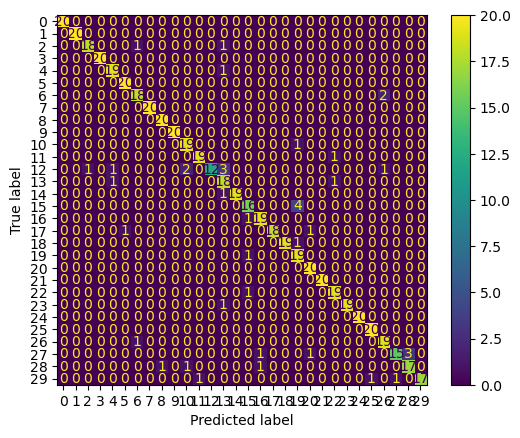

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

i = 27

model.load_state_dict(torch.load(f'2018_clinical_bestmod{i}.pth', map_location=device))

eval_model(train, test, model, task = 'classification')

## Bacteria 3

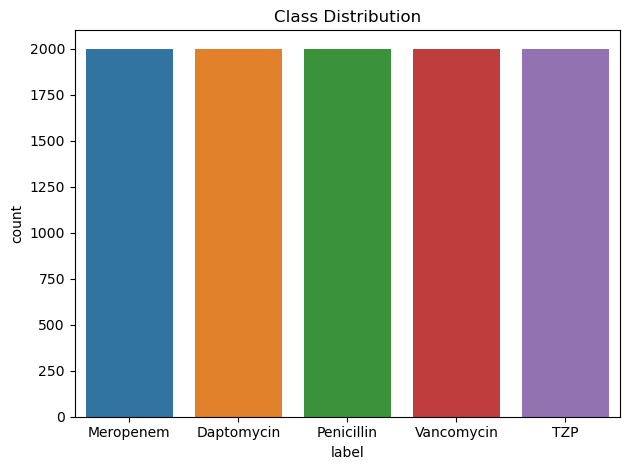

In [53]:
bacteria3 = pd.read_csv('2018_clinical.csv')
bacteria3 = bacteria3[['label'] + list(bacteria3.columns[:-1])]
plt.figure()
sns.countplot(bacteria3, x='label', order=bacteria3['label'].value_counts().index)
plt.title(f'Class Distribution')
plt.tight_layout()
plt.show()

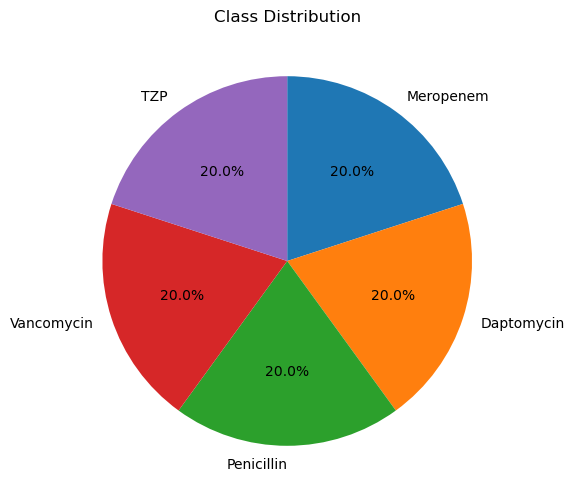

In [99]:
counts = bacteria3['label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',   
    startangle=90,      
    counterclock=False  
)
plt.title('Class Distribution')
plt.show()

In [54]:
le = LabelEncoder()
bacteria3['label'] = le.fit_transform(bacteria3['label'])
n_classes = bacteria3['label'].unique().shape[0]
input_len = bacteria3.shape[1] -1
bacteria3

,label,381.98,383.54,385.09,386.65,388.21,389.76,391.32,392.87,394.43,...,1780.9,1782.2,1783.5,1784.8,1786.0,1787.3,1788.6,1789.9,1791.2,1792.4
0,1,0.529208,0.381511,0.382170,0.333366,0.548350,0.384099,0.665001,0.352327,0.633196,...,0.483471,0.457140,0.447297,0.338510,0.444049,0.467148,0.754019,0.331965,0.536364,0.345056
1,1,0.586753,0.465573,0.519087,0.310533,0.468875,0.697084,0.471041,0.751664,0.525604,...,0.576498,0.496060,0.345738,0.544822,0.411936,0.436274,0.565438,0.362685,0.526757,0.498629
2,1,0.524157,0.558236,0.560361,0.578431,0.340869,0.342930,0.552676,0.410928,0.540757,...,0.571785,0.353427,0.502540,0.571737,0.497140,0.438505,0.363892,0.576881,0.502237,0.347691
3,1,0.459811,0.417070,0.404419,0.376692,0.710402,0.622374,0.579527,0.702315,0.343138,...,0.529797,0.475037,0.510610,0.455820,0.401015,0.391361,0.336526,0.402205,0.407596,0.458139
4,1,0.189579,0.378209,0.411329,0.288924,0.321982,0.308361,0.559065,0.483183,0.422820,...,0.356098,0.237813,0.259458,0.312202,0.364914,0.402062,0.423644,0.305313,0.233568,0.348416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,0.327230,0.619209,0.412900,0.692127,0.575295,0.317929,0.456661,0.569852,0.223098,...,0.349475,0.281144,0.417218,0.233869,0.574362,0.429305,0.539775,0.305331,0.339113,0.308998
9996,3,0.284924,0.542737,0.347398,0.265356,0.685085,0.457409,0.488727,0.536230,0.276216,...,0.357530,0.347997,0.322263,0.474565,0.270762,0.439233,0.283969,0.355345,0.119142,0.384673
9997,3,0.425475,0.629772,0.406174,0.285912,0.505069,0.694757,0.648379,0.646298,0.378639,...,0.450221,0.501808,0.287757,0.545913,0.464652,0.280099,0.523455,0.088089,0.405215,0.146834
9998,3,0.252596,0.681548,0.353859,0.482805,0.481331,0.623376,0.452343,0.398763,0.397380,...,0.486380,0.337812,0.397980,0.340722,0.518264,0.382704,0.390623,0.424686,0.367362,0.270874


In [11]:
bacteria3['label'].value_counts()

1    2000
0    2000
2    2000
4    2000
3    2000
Name: label, dtype: int64

### Random Forest

In [55]:
train, test = model_selection.train_test_split(bacteria3, test_size=0.2, random_state=1, stratify= bacteria3['label'])

test.columns = test.columns.astype(str)
train.columns = test.columns.astype(str)

y_train = train.iloc[:,0]
y_test = test.iloc[:,0]

scaler = StandardScaler()

normalized = scaler.fit_transform(train.iloc[:,1:].T).T
X_train = pd.DataFrame(normalized, columns = train.iloc[:,1:].columns)

normalized = scaler.fit_transform(test.iloc[:,1:].T).T
X_test = pd.DataFrame(normalized, columns = test.iloc[:,1:].columns)


stand = StandardScaler()

scaled = stand.fit_transform(X_train)
X_train = pd.DataFrame(scaled, columns = X_train.columns)

scaled = stand.transform(X_test)
X_test = pd.DataFrame(scaled, columns = X_test.columns)

In [85]:
rfc = RandomForestClassifier()

cv_scores = model_selection.cross_val_score(rfc, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[0.909375   0.89921875 0.9140625  0.91171875 0.909375  ]
0.9087500000000001


In [38]:
rfc = RandomForestClassifier()

rfc.fit(X_train, y_train)

train_acc = rfc.score(X_train, y_train)
test_acc = rfc.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

Train accuracy : 1.000000 - Test accuracy 0.908000


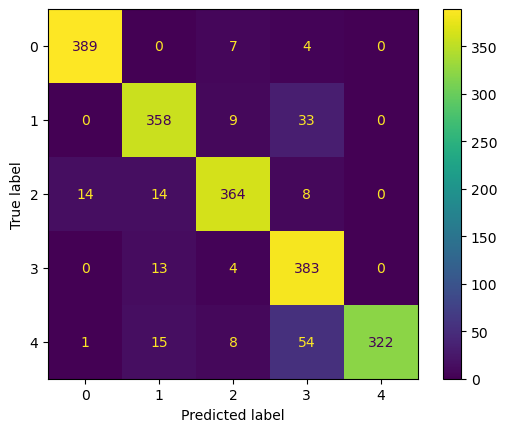

In [40]:
cm = confusion_matrix(y_test, rfc.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Train accuracy : 1.000000 - Test accuracy 0.971000
Best params {'PCA__n_components': 0.9}


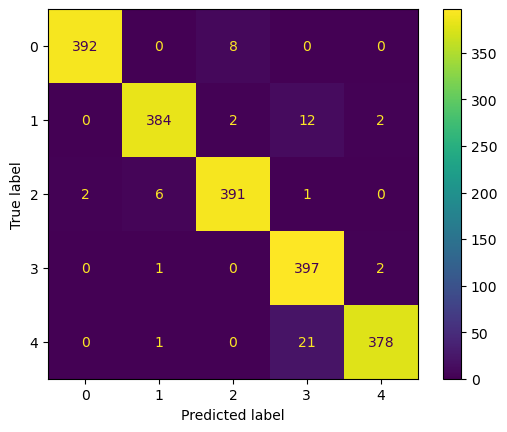

In [56]:
rfc = Pipeline([
    ('PCA', PCA()),
    ('RandomForest', RandomForestClassifier())])

param_rfc = {
    'PCA__n_components': [0.9, 0.95, 0.99]
}

search_rf = GridSearchCV(rfc, param_rfc, scoring="accuracy", cv = 5)

search_rf.fit(X_train, y_train)

train_acc = search_rf.best_estimator_.score(X_train, y_train)
test_acc = search_rf.best_estimator_.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')
print(f'Best params {search_rf.best_params_}')
cm = confusion_matrix(y_test, search_rf.best_estimator_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### SVM Classifier

In [135]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

cv_scores = model_selection.cross_val_score(svm, X_train, y_train, cv = 5, scoring= 'accuracy')
print(cv_scores)
print(cv_scores.mean())

[0.976875 0.98375  0.978125 0.9775   0.98375 ]
0.9800000000000001


Train accuracy : 1.000000 - Test accuracy 0.984500


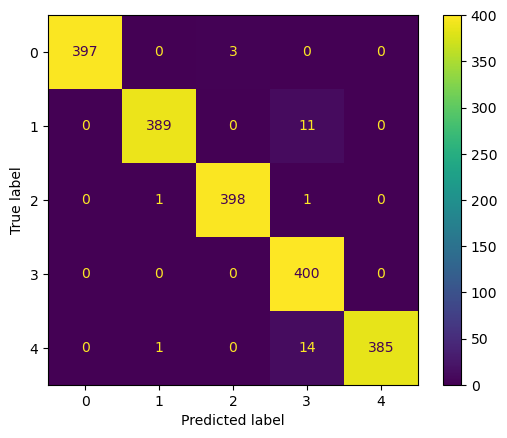

In [104]:
svm = SVC(kernel='rbf', C=1.0, gamma='scale')

svm.fit(X_train, y_train)

train_acc = svm.score(X_train, y_train)
test_acc = svm.score(X_test, y_test)

print(f'Train accuracy : {train_acc:.6f} - Test accuracy {test_acc:.6f}')

cm = confusion_matrix(y_test, svm.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### CNN

Epoch  1 — train Accuracy 0.959688 - train F1 0.959686 — val Accuracy 0.977500 - val F1 0.977527
Epoch  2 — train Accuracy 0.990313 - train F1 0.990318 — val Accuracy 0.975000 - val F1 0.975012
Epoch  3 — train Accuracy 0.995469 - train F1 0.995470 — val Accuracy 0.988750 - val F1 0.988743
Epoch  4 — train Accuracy 0.994062 - train F1 0.994063 — val Accuracy 0.988750 - val F1 0.988790
Epoch  5 — train Accuracy 0.996719 - train F1 0.996719 — val Accuracy 0.989375 - val F1 0.989378
Epoch  6 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.990000 - val F1 0.990010
Epoch  7 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.991250 - val F1 0.991260
Epoch  8 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.991250 - val F1 0.991256
Epoch  9 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.991250 - val F1 0.991256
Epoch 10 — train Accuracy 1.000000 - train F1 1.000000 — val Accuracy 0.991250 - val F1 0.991260
Epoch 11 — train Accuracy 1.00

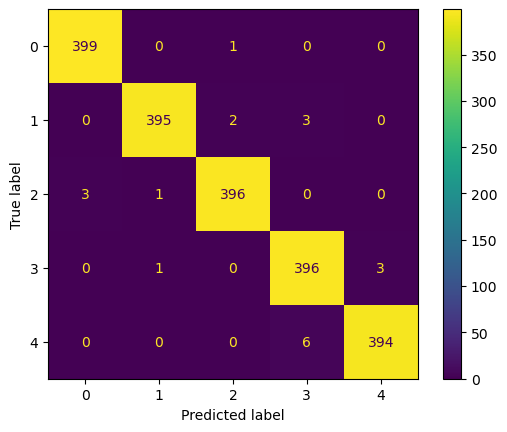

Test Accuracy 0.990000 — Test F1 0.990005


In [105]:
train, test = model_selection.train_test_split(bacteria3, test_size=0.2, random_state=1, stratify= bacteria3['label'])
train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])

model ,train_acc, train_f1, val_acc, val_f1 = train_eval_cnn(train, validation, test, epochs = 100, input_length = input_len, n_classes = n_classes, batch_size = 16, updates = True, file_name = 'cnn_bacteria3_mod.pth',earlystop = True, patience = 10)

### Raman-LLM

In [12]:
configs = Details(
    task = 'classification',
    pred_len = n_classes,      
    seq_len  = input_len,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
    dropout = 0.2, 
    n_heads = 4, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)

train, test = model_selection.train_test_split(bacteria3, test_size=0.2, random_state=1, stratify= bacteria3['label'])
train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])


model ,train_acc, train_f1, val_acc, val_f1, stand  = train_classification_model(configs, train, validation, 100, 8, True, True, file_name = 'class_model_bacteria3.pth')

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch  1 — train Accuracy : 0.810156 - train F1 0.809869 — val Accuracy 0.975625 - val F1 0.975656
Epoch  2 — train Accuracy : 0.895312 - train F1 0.895201 — val Accuracy 0.981875 - val F1 0.981902
Epoch  3 — train Accuracy : 0.906094 - train F1 0.905947 — val Accuracy 0.981250 - val F1 0.981342
Epoch  4 — train Accuracy : 0.906406 - train F1 0.906315 — val Accuracy 0.980625 - val F1 0.980690
Epoch  5 — train Accuracy : 0.918125 - train F1 0.918107 — val Accuracy 0.985000 - val F1 0.985014
Epoch  6 — train Accuracy : 0.912344 - train F1 0.912290 — val Accuracy 0.984375 - val F1 0.984345
Epoch  7 — train Accuracy : 0.917500 - train F1 0.917368 — val Accuracy 0.986875 - val F1 0.986891
Epoch  8 — train Accuracy : 0.918281 - train F1 0.918233 — val Accuracy 0.983750 - val F1 0.983763
Epoch  9 — train Accuracy : 0.917500 - train F1 0.917607 — val Accuracy 0.990625 - val F1 0.990629
Epoch 10 — train Accuracy : 0.920312 - train F1 0.920367 — val Accuracy 0.985000 - val F1 0.985021
Epoch 11 —

In [16]:
configs = Details(
    task = 'classification',
    pred_len = n_classes,      
    seq_len  = input_len,
    d_ff = 32,
    patch_len= 16, 
    stride = 8, 
    llm_layers = 8, 
    description = "This dataset contains near-infrared (NIR) spectroscopy measurements. Each spectrum includes absorbance values across " \
                  "different wavelengths. The goal is to classify each spectra given the different wavelengths " ,
    dropout = 0.2, 
    n_heads = 4, 
    d_model = 16,
    enc_in = 1,
    d_llm = 4096,
    llm_model = 'LLAMA',
    lr = 0.0001
)


train, test = model_selection.train_test_split(bacteria3, test_size=0.2, random_state=1, stratify= bacteria3['label'])

train, validation = model_selection.train_test_split(train, test_size=0.2, random_state=1, stratify= train['label'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model  = Model(configs).to(device)

model.load_state_dict(torch.load("class_model_bacteria3.pth", map_location=device))

eval_model(train, test,model, task = 'classification')

Test Accuracy 0.987500 — Test F1 0.987513


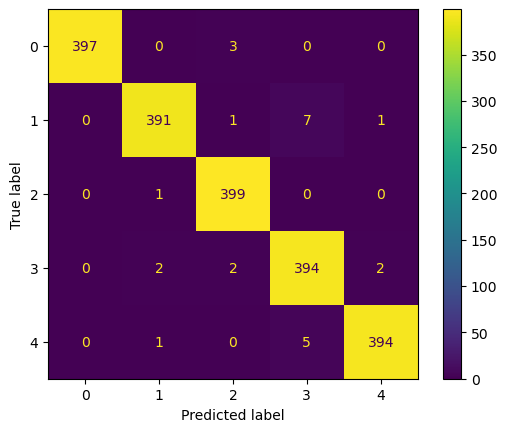

In [22]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()